# DenoiSeg Example: DSB 2018
This is an example notebook which illustrates how DenoiSeg should be trained. In this notebook we use a refined version of the Kaggle 2018 Data Science Bowl (DSB 2018) dataset. We already split the data into train and test images. From the train images we then extracted 3800 training and 670 validation patches of size 128x128. The test set contains 50 images. 


In [1]:
# Here we are just importing some libraries which are needed to run this notebook.
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

from denoiseg.models import DenoiSeg, DenoiSegConfig
from denoiseg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data
from denoiseg.utils.seg_utils import *
from denoiseg.utils.compute_precision_threshold import measure_precision

from csbdeep.utils import plot_history

import urllib
import os
import zipfile

Using TensorFlow backend.


## Downloading and  Data Loading
We created three versions of this dataset by adding Gaussian noise with zero mean and standard deviations 10 and 20. The dataset are marked with the suffixes n0, n10 and n20 accordingly.

In the next cell you can choose which `noise_level` you would like to investigate.

In [2]:
# Choose the noise level you would like to look at:
# Values: 'n0', 'n10', 'n20'
noise_level = 'n0'

In [3]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')
    
if noise_level == 'n0':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/1WXxLSqbK0ZIxF5/download'
elif noise_level == 'n10':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/dRc1AHcaH8mqeh7/download'
elif noise_level == 'n20':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/hy6xSq82kCoqqSH/download'
else:
    print('This noise level does not exist for this dataset.')

# check if data has been downloaded already
zipPath="data/DSB2018_{}.zip".format(noise_level)
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve(link, zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [4]:
# Loading of the training images
trainval_data =  np.load('data/DSB2018_{}/train/train_data.npz'.format(noise_level))
train_images = trainval_data['X_train'].astype(np.float32)
train_masks = trainval_data['Y_train']
val_images = trainval_data['X_val'].astype(np.float32)
val_masks = trainval_data['Y_val']

In [5]:
print("Shape of train_images: {}".format(train_images.shape))
print("Shape of train_masks:  {}".format(train_masks.shape))
print("Shape of val_images:   {}".format(val_images.shape))
print("Shape of val_masks:    {}".format(val_masks.shape))

Shape of train_images: (3800, 128, 128)
Shape of train_masks:  (3800, 128, 128)
Shape of val_images:   (670, 128, 128)
Shape of val_masks:    (670, 128, 128)


## Small Amounts of Annotated Training Data
With DenoiSeg we present a solution to train deep neural networks if only few annotated ground truth segmentations are available. We simulate such a scenary by zeroing out all but a fraction of the available training data. In the next cell you can specify the percentage of training images for which ground truth annotations are available.

In [6]:
# Set the percentage of annotated training images.
# Values: 0.0 (no annotated images) to 100.0 (all images get annotations)
percentage_of_annotated_training_images = 0.125
assert percentage_of_annotated_training_images >= 0.0 and percentage_of_annotated_training_images <=100.0

In [7]:
# Seed to shuffle training data (annotated GT and raw image pairs).
seed = 1 

# First we shuffle the training images to remove any bias.
X_shuffled, Y_shuffled = shuffle_train_data(train_images, train_masks, random_seed=seed)
# Here we zero out all training images which are not part of the 
# selected percentage.
X_frac, Y_frac = zero_out_train_data(X_shuffled, Y_shuffled, fraction = percentage_of_annotated_training_images)

# Now we apply data augmentation to the training patches:
# Rotate four times by 90 degree and add flipped versions.
X, Y_train_masks = augment_data(X_frac, Y_frac)
X_val, Y_val_masks = val_images, val_masks

# Here we add the channel dimension to our input images.
# Dimensionality for training has to be 'SYXC' (Sample, Y-Dimension, X-Dimension, Channel)
X = X[...,np.newaxis]
Y = convert_to_oneHot(Y_train_masks)
X_val = X_val[...,np.newaxis]
Y_val = convert_to_oneHot(Y_val_masks)
print("Shape of X:     {}".format(X.shape))
print("Shape of Y:     {}".format(Y.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of Y_val: {}".format(Y_val.shape))

Raw image size after augmentation (30400, 128, 128)
Mask size after augmentation (30400, 128, 128)
Shape of X:     (30400, 128, 128, 1)
Shape of Y:     (30400, 128, 128, 3)
Shape of X_val: (670, 128, 128, 1)
Shape of Y_val: (670, 128, 128, 3)


Next we look at a single sample. In the first column we show the input image, in the second column the background segmentation, in the third column the foreground segmentation and in the last column the border segmentation.

With the parameter `sample` you can choose different training patches. You will notice that not all of them have a segmentation ground truth.

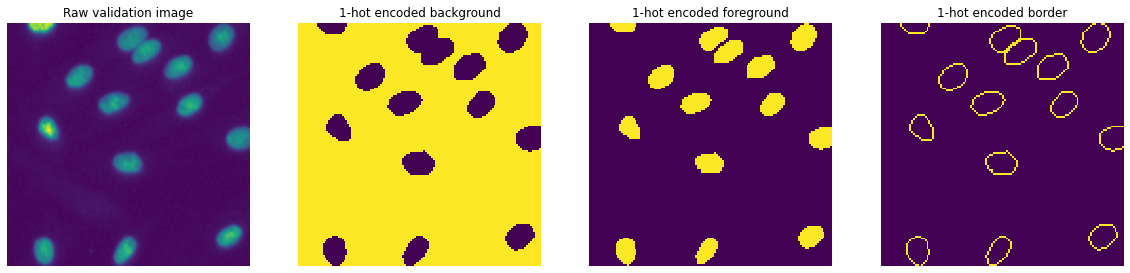

In [8]:
sample = 0
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X[sample,...,0])
plt.axis('off')
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y[sample,...,0], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y[sample,...,1], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y[sample,...,2], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded border');

### Configure network parameters

In [9]:
train_batch_size = 128
train_steps_per_epoch = max(100, min(int(X.shape[0]/train_batch_size), 400))

In the next cell, you can choose how much relative importance (weight) to assign to denoising 
and segmentation tasks by choosing appropriate value for `denoiseg_alpha` (between `0` and `1`; with `0` being
only segmentation and `1` being only denoising. Here we choose `denoiseg_alpha = 0.5`)

In [10]:
conf = DenoiSegConfig(X, unet_kern_size=3, n_channel_out=4, relative_weights = [1.0,1.0,5.0],
                      train_steps_per_epoch=train_steps_per_epoch, train_epochs=200, 
                      batch_norm=True, train_batch_size=128, unet_n_first = 32, 
                      unet_n_depth=4, denoiseg_alpha=0.5, train_tensorboard=True)

vars(conf)

{'means': ['13.496972'],
 'stds': ['18.33537'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 4,
 'train_loss': 'denoiseg',
 'unet_n_depth': 4,
 'relative_weights': [1.0, 1.0, 5.0],
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'probabilistic': False,
 'unet_residual': False,
 'unet_input_shape': (None, None, 1),
 'train_epochs': 200,
 'train_steps_per_epoch': 237,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_reduce_lr': {'monitor': 'val_loss', 'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 1.5,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'denoiseg_alpha': 0.5}

In [11]:
model_name = 'DenoiSeg_DSB18_n0_noiseAugmentation_valTestAsWell_alpha.5'
basedir = 'models'
model = DenoiSeg(conf, model_name, basedir)

In [12]:
history = model.train(X, Y, (X_val, Y_val))

/home/tbuchhol/Gitrepos/DenoiSeg/denoiseg/models/denoiseg_standard.py:144: UserWarning: small number of validation images (only 2.15642% of all images)
  warnings.warn("small number of validation images (only %.05f%% of all images)" % (100 * frac_val))


61 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 670/670 [00:09<00:00, 70.45it/s]




Epoch 1/200
237/237 [==============================] - 141s 597ms/step - loss: 0.0470 - denoiseg: 0.0470 - seg_loss: 0.0010 - denoise_loss: 0.0459 - val_loss: 0.6911 - val_denoiseg: 0.6911 - val_seg_loss: 0.6601 - val_denoise_loss: 0.0310

Epoch 2/200
237/237 [==============================] - 129s 544ms/step - loss: 0.0304 - denoiseg: 0.0304 - seg_loss: 6.9539e-04 - denoise_loss: 0.0297 - val_loss: 0.6903 - val_denoiseg: 0.6903 - val_seg_loss: 0.6636 - val_denoise_loss: 0.0267
Epoch 3/200
237/237 [==============================] - 132s 556ms/step - loss: 0.0303 - denoiseg: 0.0303 - seg_loss: 6.7743e-04 - denoise_loss: 0.0296 - val_loss: 0.5392 - val_denoiseg: 0.5392 - val_seg_loss: 0.5145 - val_denoise_loss: 0.0247
Epoch 4/200
237/237 [==============================] - 132s 558ms/step - loss: 0.0295 - denoiseg: 0.0295 - seg_loss: 5.0320e-04 - denoise_loss: 0.0290 - val_loss: 0.6492 - val_denoiseg: 0.6492 - val_seg_loss: 0.6241 - val_denoise_loss: 0.0252
Epoch 5/200
237/237 [========

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 129s 546ms/step - loss: 0.0283 - denoiseg: 0.0283 - seg_loss: 3.6913e-04 - denoise_loss: 0.0279 - val_loss: 0.9372 - val_denoiseg: 0.9372 - val_seg_loss: 0.8953 - val_denoise_loss: 0.0419
Epoch 7/200
237/237 [==============================] - 130s 547ms/step - loss: 0.0266 - denoiseg: 0.0266 - seg_loss: 3.0552e-04 - denoise_loss: 0.0263 - val_loss: 0.3839 - val_denoiseg: 0.3839 - val_seg_loss: 0.3555 - val_denoise_loss: 0.0284
Epoch 8/200
237/237 [==============================] - 129s 543ms/step - loss: 0.0269 - denoiseg: 0.0269 - seg_loss: 3.4139e-04 - denoise_loss: 0.0265 - val_loss: 0.5283 - val_denoiseg: 0.5283 - val_seg_loss: 0.5031 - val_denoise_loss: 0.0251
Epoch 9/200
237/237 [==============================] - 133s 561ms/step - loss: 0.0261 - denoiseg: 0.0261 - seg_loss: 3.4628e-04 - denoise_loss: 0.0258 - val_loss: 0.5800 - val_denoiseg: 0.5800 - val_seg_loss: 0.5551 - val_denoise_loss: 0.0248
Epoch 10/200
237/237 [==================

Epoch 40/200
237/237 [==============================] - 130s 549ms/step - loss: 0.0236 - denoiseg: 0.0236 - seg_loss: 1.5065e-04 - denoise_loss: 0.0235 - val_loss: 0.2193 - val_denoiseg: 0.2193 - val_seg_loss: 0.1960 - val_denoise_loss: 0.0233
Epoch 41/200
237/237 [==============================] - 128s 541ms/step - loss: 0.0239 - denoiseg: 0.0239 - seg_loss: 1.3538e-04 - denoise_loss: 0.0238 - val_loss: 0.2879 - val_denoiseg: 0.2879 - val_seg_loss: 0.2651 - val_denoise_loss: 0.0228
Epoch 42/200
237/237 [==============================] - 129s 545ms/step - loss: 0.0237 - denoiseg: 0.0237 - seg_loss: 1.2912e-04 - denoise_loss: 0.0235 - val_loss: 0.1889 - val_denoiseg: 0.1889 - val_seg_loss: 0.1659 - val_denoise_loss: 0.0230
Epoch 43/200
237/237 [==============================] - 128s 540ms/step - loss: 0.0237 - denoiseg: 0.0237 - seg_loss: 1.2472e-04 - denoise_loss: 0.0236 - val_loss: 0.1786 - val_denoiseg: 0.1786 - val_seg_loss: 0.1560 - val_denoise_loss: 0.0226
Epoch 44/200
 90/237 [==

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 131s 553ms/step - loss: 0.0238 - denoiseg: 0.0238 - seg_loss: 1.6759e-04 - denoise_loss: 0.0237 - val_loss: 0.2538 - val_denoiseg: 0.2538 - val_seg_loss: 0.2310 - val_denoise_loss: 0.0229
Epoch 45/200
237/237 [==============================] - 129s 543ms/step - loss: 0.0237 - denoiseg: 0.0237 - seg_loss: 1.1041e-04 - denoise_loss: 0.0236 - val_loss: 0.2795 - val_denoiseg: 0.2795 - val_seg_loss: 0.2545 - val_denoise_loss: 0.0249
Epoch 46/200
237/237 [==============================] - 128s 540ms/step - loss: 0.0236 - denoiseg: 0.0236 - seg_loss: 1.6809e-04 - denoise_loss: 0.0235 - val_loss: 0.1977 - val_denoiseg: 0.1977 - val_seg_loss: 0.1743 - val_denoise_loss: 0.0234
Epoch 47/200
237/237 [==============================] - 129s 543ms/step - loss: 0.0236 - denoiseg: 0.0236 - seg_loss: 1.2811e-04 - denoise_loss: 0.0235 - val_loss: 0.1951 - val_denoiseg: 0.1951 - val_seg_loss: 0.1720 - val_denoise_loss: 0.0231
Epoch 48/200
237/237 [===============

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:27 - loss: 0.0234 - denoiseg: 0.0234 - seg_loss: 1.2860e-04 - denoise_loss: 0.0233

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 127s 538ms/step - loss: 0.0235 - denoiseg: 0.0235 - seg_loss: 1.2652e-04 - denoise_loss: 0.0234 - val_loss: 0.1625 - val_denoiseg: 0.1625 - val_seg_loss: 0.1389 - val_denoise_loss: 0.0236
Epoch 55/200
237/237 [==============================] - 128s 541ms/step - loss: 0.0236 - denoiseg: 0.0236 - seg_loss: 1.0800e-04 - denoise_loss: 0.0235 - val_loss: 0.1622 - val_denoiseg: 0.1622 - val_seg_loss: 0.1387 - val_denoise_loss: 0.0234
Epoch 56/200
 64/237 [=======>......................] - ETA: 1:29 - loss: 0.0236 - denoiseg: 0.0236 - seg_loss: 1.2741e-04 - denoise_loss: 0.0235

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:28 - loss: 0.0236 - denoiseg: 0.0236 - seg_loss: 1.2354e-04 - denoise_loss: 0.0235

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 125s 528ms/step - loss: 0.0234 - denoiseg: 0.0234 - seg_loss: 1.1823e-04 - denoise_loss: 0.0233 - val_loss: 0.1514 - val_denoiseg: 0.1514 - val_seg_loss: 0.1287 - val_denoise_loss: 0.0226
Epoch 57/200
237/237 [==============================] - 126s 532ms/step - loss: 0.0235 - denoiseg: 0.0235 - seg_loss: 9.0843e-05 - denoise_loss: 0.0234 - val_loss: 0.1822 - val_denoiseg: 0.1822 - val_seg_loss: 0.1593 - val_denoise_loss: 0.0229
Epoch 58/200
 77/237 [========>.....................] - ETA: 1:24 - loss: 0.0233 - denoiseg: 0.0233 - seg_loss: 1.3501e-04 - denoise_loss: 0.0232

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 127s 538ms/step - loss: 0.0235 - denoiseg: 0.0235 - seg_loss: 1.2854e-04 - denoise_loss: 0.0233 - val_loss: 0.1568 - val_denoiseg: 0.1568 - val_seg_loss: 0.1342 - val_denoise_loss: 0.0226
Epoch 59/200
237/237 [==============================] - 125s 526ms/step - loss: 0.0233 - denoiseg: 0.0233 - seg_loss: 1.2148e-04 - denoise_loss: 0.0232 - val_loss: 0.1466 - val_denoiseg: 0.1466 - val_seg_loss: 0.1236 - val_denoise_loss: 0.0231
Epoch 60/200
237/237 [==============================] - 129s 545ms/step - loss: 0.0234 - denoiseg: 0.0234 - seg_loss: 1.1029e-04 - denoise_loss: 0.0233 - val_loss: 0.1494 - val_denoiseg: 0.1494 - val_seg_loss: 0.1265 - val_denoise_loss: 0.0229
Epoch 61/200
237/237 [==============================] - 129s 546ms/step - loss: 0.0234 - denoiseg: 0.0234 - seg_loss: 1.2883e-04 - denoise_loss: 0.0233 - val_loss: 0.1489 - val_denoiseg: 0.1489 - val_seg_loss: 0.1263 - val_denoise_loss: 0.0226
Epoch 62/200
237/237 [===============

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131030). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 127s 536ms/step - loss: 0.0234 - denoiseg: 0.0234 - seg_loss: 1.1364e-04 - denoise_loss: 0.0233 - val_loss: 0.1429 - val_denoiseg: 0.1429 - val_seg_loss: 0.1202 - val_denoise_loss: 0.0226
Epoch 71/200
237/237 [==============================] - 125s 528ms/step - loss: 0.0233 - denoiseg: 0.0233 - seg_loss: 5.9568e-05 - denoise_loss: 0.0232 - val_loss: 0.1445 - val_denoiseg: 0.1445 - val_seg_loss: 0.1213 - val_denoise_loss: 0.0232
Epoch 72/200
237/237 [==============================] - 127s 535ms/step - loss: 0.0233 - denoiseg: 0.0233 - seg_loss: 1.5109e-04 - denoise_loss: 0.0231 - val_loss: 0.1450 - val_denoiseg: 0.1450 - val_seg_loss: 0.1224 - val_denoise_loss: 0.0226

Epoch 00072: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.
Epoch 73/200
237/237 [==============================] - 125s 527ms/step - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 8.1898e-05 - denoise_loss: 0.0230 - val_loss: 0.1421 - val_denoiseg: 0.1421 - val

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 126s 532ms/step - loss: 0.0231 - denoiseg: 0.0231 - seg_loss: 1.2718e-04 - denoise_loss: 0.0229 - val_loss: 0.1383 - val_denoiseg: 0.1383 - val_seg_loss: 0.1157 - val_denoise_loss: 0.0226
Epoch 78/200
111/237 [=============>................] - ETA: 1:05 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 2.1262e-05 - denoise_loss: 0.0230

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 126s 532ms/step - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 5.8378e-05 - denoise_loss: 0.0230 - val_loss: 0.1446 - val_denoiseg: 0.1446 - val_seg_loss: 0.1217 - val_denoise_loss: 0.0229
Epoch 79/200
237/237 [==============================] - 124s 524ms/step - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 7.8721e-05 - denoise_loss: 0.0229 - val_loss: 0.1378 - val_denoiseg: 0.1378 - val_seg_loss: 0.1153 - val_denoise_loss: 0.0225
Epoch 80/200
237/237 [==============================] - 128s 542ms/step - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.2676e-04 - denoise_loss: 0.0229 - val_loss: 0.1415 - val_denoiseg: 0.1415 - val_seg_loss: 0.1189 - val_denoise_loss: 0.0227
Epoch 81/200
237/237 [==============================] - 127s 536ms/step - loss: 0.0231 - denoiseg: 0.0231 - seg_loss: 1.2516e-04 - denoise_loss: 0.0230 - val_loss: 0.1396 - val_denoiseg: 0.1396 - val_seg_loss: 0.1171 - val_denoise_loss: 0.0225
Epoch 82/200
237/237 [===============

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 27s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1505e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 16s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0583e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 15s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0532e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 15s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0481e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 14s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0381e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 126s 532ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8546e-05 - denoise_loss: 0.0227 - val_loss: 0.1402 - val_denoiseg: 0.1402 - val_seg_loss: 0.1177 - val_denoise_loss: 0.0225
Epoch 92/200
237/237 [==============================] - 123s 519ms/step - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1429e-04 - denoise_loss: 0.0228 - val_loss: 0.1393 - val_denoiseg: 0.1393 - val_seg_loss: 0.1167 - val_denoise_loss: 0.0226
Epoch 93/200
237/237 [==============================] - 126s 532ms/step - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.7278e-05 - denoise_loss: 0.0228 - val_loss: 0.1366 - val_denoiseg: 0.1366 - val_seg_loss: 0.1139 - val_denoise_loss: 0.0227
Epoch 94/200
237/237 [==============================] - 123s 520ms/step - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0123e-04 - denoise_loss: 0.0228 - val_loss: 0.1383 - val_denoiseg: 0.1383 - val_seg_loss: 0.1159 - val_denoise_loss: 0.0224
Epoch 95/200
237/237 [===============

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 21s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 6.0114e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 123s 519ms/step - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 8.2254e-05 - denoise_loss: 0.0228 - val_loss: 0.1347 - val_denoiseg: 0.1347 - val_seg_loss: 0.1122 - val_denoise_loss: 0.0225
Epoch 100/200
237/237 [==============================] - 120s 508ms/step - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.5397e-05 - denoise_loss: 0.0229 - val_loss: 0.1378 - val_denoiseg: 0.1378 - val_seg_loss: 0.1154 - val_denoise_loss: 0.0224
Epoch 101/200
155/237 [==================>...........] - ETA: 41s - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.0733e-04 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139472). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 121s 510ms/step - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0123e-04 - denoise_loss: 0.0228 - val_loss: 0.1376 - val_denoiseg: 0.1376 - val_seg_loss: 0.1152 - val_denoise_loss: 0.0224
Epoch 102/200
237/237 [==============================] - 123s 521ms/step - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 9.9404e-05 - denoise_loss: 0.0228 - val_loss: 0.1357 - val_denoiseg: 0.1357 - val_seg_loss: 0.1132 - val_denoise_loss: 0.0225
Epoch 103/200
237/237 [==============================] - 122s 516ms/step - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0462e-04 - denoise_loss: 0.0228 - val_loss: 0.1358 - val_denoiseg: 0.1358 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0224
Epoch 104/200
237/237 [==============================] - 124s 525ms/step - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 9.8009e-05 - denoise_loss: 0.0228 - val_loss: 0.1358 - val_denoiseg: 0.1358 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0225
Epoch 105/200
237/237 [===========

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 31s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0250e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 121s 511ms/step - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 8.3318e-05 - denoise_loss: 0.0228 - val_loss: 0.1373 - val_denoiseg: 0.1373 - val_seg_loss: 0.1149 - val_denoise_loss: 0.0224

Epoch 00109: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 110/200
237/237 [==============================] - 118s 497ms/step - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 8.3112e-05 - denoise_loss: 0.0228 - val_loss: 0.1365 - val_denoiseg: 0.1365 - val_seg_loss: 0.1141 - val_denoise_loss: 0.0224
Epoch 111/200
237/237 [==============================] - 119s 503ms/step - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 9.5148e-05 - denoise_loss: 0.0228 - val_loss: 0.1374 - val_denoiseg: 0.1374 - val_seg_loss: 0.1148 - val_denoise_loss: 0.0225
Epoch 112/200
237/237 [==============================] - 118s 497ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8461e-05 - denoise_loss: 0.0227 - val_loss: 0.1360 - val_denoiseg: 0.1360 - v

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2184e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1060e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9430e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8897e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8896e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 116s 488ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0008e-04 - denoise_loss: 0.0227 - val_loss: 0.1366 - val_denoiseg: 0.1366 - val_seg_loss: 0.1143 - val_denoise_loss: 0.0224
Epoch 114/200
136/237 [================>.............] - ETA: 50s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0056e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 48s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.8786e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 46s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6042e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 118s 500ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4425e-05 - denoise_loss: 0.0227 - val_loss: 0.1369 - val_denoiseg: 0.1369 - val_seg_loss: 0.1145 - val_denoise_loss: 0.0224
Epoch 115/200
133/237 [===============>..............] - ETA: 50s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1289e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 49s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1122e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 48s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1626e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 47s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1457e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 47s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1375e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 45s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1135e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0981e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0612e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0223e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0170e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0065e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 116s 491ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6552e-05 - denoise_loss: 0.0227 - val_loss: 0.1354 - val_denoiseg: 0.1354 - val_seg_loss: 0.1131 - val_denoise_loss: 0.0224
Epoch 116/200
125/237 [==============>...............] - ETA: 53s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.0976e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.9085e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 48s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.5635e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 4.8400e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 4.7821e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 4.7536e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.6364e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.3877e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.5414e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.4671e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.3944e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.3587e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.2884e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.1859e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 115s 487ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8401e-05 - denoise_loss: 0.0228 - val_loss: 0.1364 - val_denoiseg: 0.1364 - val_seg_loss: 0.1140 - val_denoise_loss: 0.0224
Epoch 117/200
137/237 [================>.............] - ETA: 48s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0233e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 47s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9079e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 46s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8514e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 44s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8869e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 43s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7796e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0057e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 115s 486ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6257e-05 - denoise_loss: 0.0227 - val_loss: 0.1377 - val_denoiseg: 0.1377 - val_seg_loss: 0.1153 - val_denoise_loss: 0.0224
Epoch 118/200
162/237 [===================>..........] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0542e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1421e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1352e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1283e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230549). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1148e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0951e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0887e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0761e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0667e-04 - denoise_loss: 0.0227- ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0518e-04 - denoise_loss: 0.0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0609e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0885e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0826e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1138e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1426e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132122). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 117s 492ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0664e-04 - denoise_loss: 0.0227 - val_loss: 0.1372 - val_denoiseg: 0.1372 - val_seg_loss: 0.1148 - val_denoise_loss: 0.0225
Epoch 119/200
126/237 [==============>...............] - ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.1916e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.1508e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 51s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.1105e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 50s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 4.9935e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.8703e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 114s 482ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3964e-05 - denoise_loss: 0.0227 - val_loss: 0.1372 - val_denoiseg: 0.1372 - val_seg_loss: 0.1148 - val_denoise_loss: 0.0224

Epoch 00119: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 120/200
133/237 [===============>..............] - ETA: 49s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9272e-05 - denoise_loss: 0.0227- ETA: 50s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0635e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 47s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7303e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144522). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 46s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5419e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7063e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8226e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6401e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5809e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3521e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2968e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146298). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2422e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 114s 482ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9907e-05 - denoise_loss: 0.0228 - val_loss: 0.1356 - val_denoiseg: 0.1356 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0224
Epoch 121/200
127/237 [===============>..............] - ETA: 53s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1061e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 52s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0889e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 48s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0329e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 43s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5559e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 42s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4913e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 41s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3647e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 41s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3027e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 39s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0626e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0082e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 28s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.7738e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 26s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6626e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 26s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6095e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137853). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 22s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4691e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 22s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4192e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2254e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 18s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9936e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9486e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7731e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6880e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7139e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 8s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3009e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 7s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2644e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 7s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2272e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6830e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180081). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6448e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172428). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 113s 477ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3101e-05 - denoise_loss: 0.0227 - val_loss: 0.1372 - val_denoiseg: 0.1372 - val_seg_loss: 0.1149 - val_denoise_loss: 0.0223
Epoch 122/200
128/237 [===============>..............] - ETA: 50s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0832e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 50s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0748e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174577). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 47s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0347e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138073). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1585e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146648). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1507e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1430e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1354e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1133e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1234e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 111s 469ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0236e-04 - denoise_loss: 0.0227 - val_loss: 0.1368 - val_denoiseg: 0.1368 - val_seg_loss: 0.1144 - val_denoise_loss: 0.0223
Epoch 123/200
  2/237 [..............................] - ETA: 55s - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 0.0000e+00 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 111s 469ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0875e-04 - denoise_loss: 0.0227 - val_loss: 0.1358 - val_denoiseg: 0.1358 - val_seg_loss: 0.1134 - val_denoise_loss: 0.0224
Epoch 124/200
130/237 [===============>..............] - ETA: 49s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 4.8921e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 4.2233e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.7002e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.6270e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.5851e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.4634e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9121e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8638e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8096e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7574e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4099e-05 - denoise_loss: 0.0228- ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6047e-05 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7249e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6280e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5331e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3496e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212816). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3050e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2171e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4840e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4403e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 111s 469ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0949e-05 - denoise_loss: 0.0228 - val_loss: 0.1357 - val_denoiseg: 0.1357 - val_seg_loss: 0.1134 - val_denoise_loss: 0.0223
Epoch 125/200
  2/237 [..............................] - ETA: 50s - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 0.0000e+00 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 45s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3148e-05 - denoise_loss: 0.0226- ETA: 48s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4451e-05 - denoise_loss

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 39s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6973e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 35s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3665e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3275e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 113s 478ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1346e-05 - denoise_loss: 0.0227 - val_loss: 0.1364 - val_denoiseg: 0.1364 - val_seg_loss: 0.1141 - val_denoise_loss: 0.0223
Epoch 126/200
134/237 [===============>..............] - ETA: 47s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0463e-04 - denoise_loss: 0.0227- ETA: 51s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0912e-04 - denoise_loss:

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 46s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0309e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0087e-04 - denoise_loss: 0.0227- ETA: 46s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0160e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0015e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 44s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9438e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 44s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8737e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180420). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6706e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6043e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5390e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4110e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2863e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0009e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8812e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7569e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6357e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5762e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0019e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7909e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6268e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7087e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6551e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0374e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6890e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6401e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0438e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0400e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0350e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0250e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0422e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0012e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9666e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 111s 469ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2939e-05 - denoise_loss: 0.0227 - val_loss: 0.1364 - val_denoiseg: 0.1364 - val_seg_loss: 0.1140 - val_denoise_loss: 0.0224
Epoch 127/200
133/237 [===============>..............] - ETA: 49s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5505e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 48s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4867e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.284617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 47s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3009e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 46s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2407e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.297771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0654e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.308372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.288415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8974e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7892e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7362e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 113s 475ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9271e-05 - denoise_loss: 0.0227 - val_loss: 0.1362 - val_denoiseg: 0.1362 - val_seg_loss: 0.1139 - val_denoise_loss: 0.0223
Epoch 128/200
142/237 [================>.............] - ETA: 44s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4948e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208124). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4740e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4638e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4342e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3964e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210178). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3783e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3434e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3102e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2710e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1632e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1509e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1449e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1272e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2291e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2232e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2174e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2003e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2337e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267031). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2224e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.280224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2112e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2208e-04 - denoise_loss: 0.02 - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2153e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.281302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2592e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.295534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2480e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283134). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2537e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2375e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2268e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2164e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2061e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 112s 471ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2010e-04 - denoise_loss: 0.0227 - val_loss: 0.1366 - val_denoiseg: 0.1366 - val_seg_loss: 0.1142 - val_denoise_loss: 0.0224
Epoch 129/200
135/237 [================>.............] - ETA: 48s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8121e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1743e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0207e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8103e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7088e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5137e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3874e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213702). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2838e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186687). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2330e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1332e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9407e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8940e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8478e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2530e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7260e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186298). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6778e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6301e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3993e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2667e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0970e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8165e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 113s 475ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9876e-05 - denoise_loss: 0.0227 - val_loss: 0.1351 - val_denoiseg: 0.1351 - val_seg_loss: 0.1127 - val_denoise_loss: 0.0224

Epoch 00129: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 130/200
137/237 [================>.............] - ETA: 46s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6234e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 46s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5610e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 43s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2047e-05 - denoise_loss: 0.0227- ETA: 44s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3202e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 41s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0385e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9306e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212844). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8778e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252854). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0431e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248293). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 39s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9380e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7853e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4569e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5844e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 33s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4797e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3776e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 30s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0859e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219765). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 29s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0392e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 29s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9930e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 27s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8575e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 26s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7710e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 25s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7283e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6443e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 111s 470ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4286e-05 - denoise_loss: 0.0227 - val_loss: 0.1361 - val_denoiseg: 0.1361 - val_seg_loss: 0.1138 - val_denoise_loss: 0.0223
Epoch 131/200
144/237 [=================>............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7107e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5776e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4482e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3848e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147905). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 112s 471ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9461e-05 - denoise_loss: 0.0227 - val_loss: 0.1361 - val_denoiseg: 0.1361 - val_seg_loss: 0.1137 - val_denoise_loss: 0.0224
Epoch 132/200
139/237 [================>.............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1019e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 44s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1027e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0874e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2255e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1867e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1291e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151229). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1290e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1431e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1660e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1629e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1367e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1303e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 112s 472ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0108e-04 - denoise_loss: 0.0227 - val_loss: 0.1359 - val_denoiseg: 0.1359 - val_seg_loss: 0.1136 - val_denoise_loss: 0.0223
Epoch 133/200
138/237 [================>.............] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0503e-04 - denoise_loss: 0.0226  ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0817e-04 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 57s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0428e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 56s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0280e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.317578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 55s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1267e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 54s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1818e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0417e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 33s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0302e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0189e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 29s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0527e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0361e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0307e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0253e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 23s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0225e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0174e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 134s 565ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1947e-05 - denoise_loss: 0.0227 - val_loss: 0.1361 - val_denoiseg: 0.1361 - val_seg_loss: 0.1137 - val_denoise_loss: 0.0224
Epoch 134/200
113/237 [=============>................] - ETA: 55s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.1969e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 54s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.1426e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1832e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0229e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9650e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8515e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7426e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5156e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3426e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1757e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191951). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1214e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214147). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9623e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9105e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7586e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211649). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7263e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8945e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8464e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7989e-05 - denoise_loss: 0.022 - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7518e-05 - denoise_loss: 0.022 - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7060e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4367e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5238e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3953e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3729e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2904e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1696e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2546e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139710). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 111s 467ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1015e-05 - denoise_loss: 0.0227 - val_loss: 0.1362 - val_denoiseg: 0.1362 - val_seg_loss: 0.1137 - val_denoise_loss: 0.0225
Epoch 135/200
 45/237 [====>.........................] - ETA: 1:16 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.1057e-04 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:16 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.0817e-04 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:16 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0587e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:08 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0790e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:08 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0495e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5764e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 59s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1924e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155367). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1069e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0991e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0915e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0765e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0549e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.280380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0808e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1411e-04 - denoise_loss: 0.0227- ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0728e-04 - denoise_loss: 0.022 - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1774e-04 - denoise_loss: 0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1272e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0452e-04 - denoise_loss: 0.0226- ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0616e-04 - denoi

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0320e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0270e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0221e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0172e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0124e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0076e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0699e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275272). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1023e-04 - denoise_loss: 0.0226 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.291177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0973e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0922e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0872e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0823e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0725e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0582e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0443e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0352e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0132e-04 - denoise_loss: 0.0226 ETA: 1s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0175e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0089e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170066). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 110s 463ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0047e-04 - denoise_loss: 0.0226 - val_loss: 0.1358 - val_denoiseg: 0.1358 - val_seg_loss: 0.1135 - val_denoise_loss: 0.0223
Epoch 136/200
  1/237 [..............................] - ETA: 49s - loss: 0.0222 - denoiseg: 0.0222 - seg_loss: 0.0000e+00 - denoise_loss: 0.0222

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:25 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 0.0000e+00 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:17 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 0.0000e+00 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:19 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 0.0000e+00 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:19 - loss: 0.0224 - denoiseg: 0.0224 - seg_loss: 0.0000e+00 - denoise_loss: 0.0224

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:16 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 1.7291e-07 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 1:04 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4277e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 57s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2867e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 56s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2629e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0662e-04 - denoise_loss: 0.0227- ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0980e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0362e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0078e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0141e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0073e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0006e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5028e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.279590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0130e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7683e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7105e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5969e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.290599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5411e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3776e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.292425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2195e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1680e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0667e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232105). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0169e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220853). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3505e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5892e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3884e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3395e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1958e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8189e-05 - denoise_loss: 0.0227 - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9419e-05 - denoise_loss: 0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 109s 461ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0400e-04 - denoise_loss: 0.0227 - val_loss: 0.1359 - val_denoiseg: 0.1359 - val_seg_loss: 0.1136 - val_denoise_loss: 0.0223
Epoch 137/200
 16/237 [=>............................] - ETA: 1:30 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.0439e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:31 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.2612e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:32 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3258e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:32 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2052e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:33 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1528e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:28 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.6766e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:27 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 8.4873e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:26 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.8811e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179989). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2937e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:10 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1067e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 48s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5928e-05 - denoise_loss: 0.0227- ETA: 49s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6723e-05 - denoise_loss: 0.0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.9021e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9370e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8311e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7793e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7281e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.274457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7626e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6643e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5685e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5215e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4751e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1591e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1108e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.289925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0631e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.292960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8777e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.294630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.292922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7882e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.290435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7007e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.288151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.286049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6577e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5731e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2208e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226117). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1766e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0468e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.289447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0052e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9218e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7999e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7601e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5671e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5296e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5639e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5270e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4543e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4184e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3478e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2443e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.0792e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.0469e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7685e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6304e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 110s 463ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5598e-05 - denoise_loss: 0.0227 - val_loss: 0.1353 - val_denoiseg: 0.1353 - val_seg_loss: 0.1130 - val_denoise_loss: 0.0223
Epoch 138/200
 42/237 [====>.........................] - ETA: 1:20 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.8168e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:20 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7256e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144272). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:20 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5500e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:19 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3337e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145328). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 48s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.8959e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 46s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6869e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245073). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 45s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5383e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 44s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4903e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168237). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 41s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9122e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.8649e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.8182e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7721e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 39s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6818e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 38s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5939e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5508e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263844). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5082e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3839e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 8s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3130e-05 - denoise_loss: 0.0227 - ETA: 20s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3926e-05 -  - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5215e-05 - denoise_l

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 108s 455ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5049e-05 - denoise_loss: 0.0227 - val_loss: 0.1353 - val_denoiseg: 0.1353 - val_seg_loss: 0.1130 - val_denoise_loss: 0.0223
Epoch 139/200
 84/237 [=========>....................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9876e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9020e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130687). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 1:01 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7134e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174814). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6218e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5319e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 59s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4436e-05 - denoise_loss: 0.0227 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2719e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1063e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 57s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9466e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 55s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7185e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 54s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5719e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2263e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 51s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1605e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 50s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5165e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 49s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3689e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 49s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7461e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 48s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5996e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 47s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5279e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7339e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0022e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9542e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8925e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267818). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8261e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6321e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.297852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.288122). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5070e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.288028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4457e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3852e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2081e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8732e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8198e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7148e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6632e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5121e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1912e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9562e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9003e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7362e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6827e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6298e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4745e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3737e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2750e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8925e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8413e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7403e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221450). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5927e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4028e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2202e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1757e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9601e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8351e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.284602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7135e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263329). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.291847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6343e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.291554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5565e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263311). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5186e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.285941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4429e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.279543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3318e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5324e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4586e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4221e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2794e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 111s 470ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2444e-05 - denoise_loss: 0.0227 - val_loss: 0.1355 - val_denoiseg: 0.1355 - val_seg_loss: 0.1131 - val_denoise_loss: 0.0224

Epoch 00139: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
Epoch 140/200
  1/237 [..............................] - ETA: 43s - loss: 0.0221 - denoiseg: 0.0221 - seg_loss: 0.0000e+00 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  2/237 [..............................] - ETA: 1:04 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 2.1669e-04 - denoise_loss: 0.0223

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:33 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.8195e-04 - denoise_loss: 0.0225 ETA: 1:25 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.7292e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:24 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.2130e-04 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:17 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.3480e-04 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:22 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1201e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188018). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:22 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0771e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:22 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6563e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.302837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:22 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3344e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:22 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7544e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:22 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2395e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:22 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7817e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:16 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.6897e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.2446e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:14 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.0465e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.9548e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.8660e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.6959e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.6146e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7500e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132577). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1462e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0728e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 108s 455ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5620e-05 - denoise_loss: 0.0227 - val_loss: 0.1354 - val_denoiseg: 0.1354 - val_seg_loss: 0.1131 - val_denoise_loss: 0.0223
Epoch 141/200
 21/237 [=>............................] - ETA: 1:26 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 2.0523e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:26 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.7957e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:26 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.8848e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:25 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.6899e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199984). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:25 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.5314e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:25 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.4413e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:24 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3613e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:23 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2896e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:23 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2566e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:20 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2598e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:20 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.4898e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:19 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.4336e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:18 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3816e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:17 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3331e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:16 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2879e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2065e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1635e-04 - denoise_loss: 0.0227 ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2432e-04 - denoise_lo

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1345e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1068e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0934e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 1:04 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0331e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 1:03 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2975e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 1:03 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3826e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3532e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159567). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3390e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 22s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1850e-04 - denoise_loss: 0.0227- ETA: 28s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2256e-04 - denoise

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 20s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1604e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 19s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1544e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 17s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1407e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 17s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2160e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 16s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2039e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 14s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1804e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 108s 456ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1417e-04 - denoise_loss: 0.0227 - val_loss: 0.1356 - val_denoiseg: 0.1356 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0223
Epoch 142/200
  1/237 [..............................] - ETA: 31s - loss: 0.0219 - denoiseg: 0.0219 - seg_loss: 0.0000e+00 - denoise_loss: 0.0219

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  2/237 [..............................] - ETA: 1:05 - loss: 0.0224 - denoiseg: 0.0224 - seg_loss: 0.0000e+00 - denoise_loss: 0.0224

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:09 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.1439e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201045). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:24 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2839e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:24 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.8785e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.2846e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.4669e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.3828e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242680). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.0708e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 55s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.8105e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 46s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3607e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3724e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0111e-04 - denoise_loss: 0.0227- ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0123e-04 - 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0060e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0009e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7609e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5713e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4793e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3890e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3010e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1712e-05 - denoise_loss: 0.0227 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0450e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0037e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9627e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 108s 456ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4791e-05 - denoise_loss: 0.0227 - val_loss: 0.1358 - val_denoiseg: 0.1358 - val_seg_loss: 0.1134 - val_denoise_loss: 0.0223
Epoch 143/200
 12/237 [>.............................] - ETA: 1:19 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.6589e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:21 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.4219e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:23 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.7795e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:24 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.6748e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:25 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.2756e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174226). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:25 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0934e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151919). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:24 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.8754e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:24 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5668e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:23 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.8455e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229564). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:23 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5794e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:22 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8609e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6555e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2579e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0375e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 1:02 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6267e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4655e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4160e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.282863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 35s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3191e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 35s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2716e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1784e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2914e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2454e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 22s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4808e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 22s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4350e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 20s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3173e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 19s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2302e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 18s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1030e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9393e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6240e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7521e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6754e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5999e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5627e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4170e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3813e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 104s 440ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3460e-05 - denoise_loss: 0.0227 - val_loss: 0.1357 - val_denoiseg: 0.1357 - val_seg_loss: 0.1134 - val_denoise_loss: 0.0223
Epoch 144/200
  2/237 [..............................] - ETA: 1:03 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 0.0000e+00 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 52s - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 0.0000e+00 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:11 - loss: 0.0224 - denoiseg: 0.0224 - seg_loss: 7.0191e-06 - denoise_loss: 0.0224

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:17 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 5.8493e-06 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:18 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 5.0137e-06 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:18 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4106e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:17 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2091e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5822e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3161e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.8562e-05 - denoise_loss: 0.0226 ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.0026e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.5838e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.3356e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.1086e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244122). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.8033e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.5314e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206059). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.4475e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.2973e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.5328e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.4374e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.1719e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.0885e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.7801e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145985). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.6395e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:06 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.5069e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 46s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5880e-05 - denoise_loss: 0.0227- ETA: 49s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2329e-05 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 45s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7535e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 45s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6866e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 44s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6203e-05 - denoise_loss: 0.022 - ETA: 44s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5550e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5812e-05 - denoise_loss: 0.0227- ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3958e-05 - denoise_loss: 0.0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4559e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4968e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4360e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3165e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 33s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2001e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0865e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 30s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8675e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 29s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5813e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 28s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6686e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 27s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5575e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 26s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5028e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2389e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228207). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 23s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1374e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0874e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9892e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8846e-05 - denoise_loss: 0.0227 ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0893e-05 - denoise_lo

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8448e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7662e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7282e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8092e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7333e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6958e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6586e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 104s 439ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5491e-05 - denoise_loss: 0.0227 - val_loss: 0.1356 - val_denoiseg: 0.1356 - val_seg_loss: 0.1132 - val_denoise_loss: 0.0223
Epoch 145/200
 28/237 [==>...........................] - ETA: 1:25 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1698e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135932). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:24 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0918e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:24 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0566e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:24 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0236e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:24 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.9255e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:23 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4315e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172682). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:23 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.6971e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 1:03 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2533e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2254e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4255e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4106e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 44s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0294e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0144e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9969e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7842e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7153e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5803e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9201e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0156e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8962e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8328e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246226). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7701e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269742). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6472e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243436). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4105e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0235e-05 - denoise_loss: 0.0227- ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2404e-05 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 28s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8671e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 27s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8161e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 25s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6621e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5664e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5194e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249583). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 23s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4728e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 23s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4268e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 22s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2916e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 21s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2038e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9677e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8311e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4389e-05 - denoise_loss: 0.0227 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3470e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141222). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2632e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1809e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2080e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216082). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1687e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0501e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0113e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9728e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9869e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 107s 450ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9111e-05 - denoise_loss: 0.0227 - val_loss: 0.1357 - val_denoiseg: 0.1357 - val_seg_loss: 0.1134 - val_denoise_loss: 0.0223
Epoch 146/200
  2/237 [..............................] - ETA: 51s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 0.0000e+00 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:03 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 0.0000e+00 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:13 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 0.0000e+00 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:20 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 0.0000e+00 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176134). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:10 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 0.0000e+00 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 0.0000e+00 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:14 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1952e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:15 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0996e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:16 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1632e-05 - denoise_loss: 0.0227 ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0181e-04 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:16 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.9763e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:16 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6740e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:16 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3894e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:16 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8678e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:16 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6281e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7864e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:14 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 6.9400e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7924e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6508e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3848e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.1392e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2099e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.0217e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:06 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.5213e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5974e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3421e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:03 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.0289e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:02 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4893e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9966e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 35s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9378e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 35s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8797e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1532e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0949e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 33s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.8686e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0166e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 31s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.9793e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 30s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.8584e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 29s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.7403e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 28s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.8392e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 28s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.7241e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275329). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 26s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5564e-05 - denoise_loss: 0.0226- ETA: 27s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6117e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 25s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0380e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 25s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0322e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0652e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0593e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 23s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0535e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0865e-04 - denoise_loss: 0.0227- ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1055e-04 - denoise_loss: 0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0814e-04 - denoise_loss: 0.0227 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0714e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0472e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0794e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0746e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 103s 434ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0691e-04 - denoise_loss: 0.0227 - val_loss: 0.1355 - val_denoiseg: 0.1355 - val_seg_loss: 0.1131 - val_denoise_loss: 0.0223
Epoch 147/200
  2/237 [..............................] - ETA: 1:03 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 0.0000e+00 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:18 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 4.2048e-04 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:21 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 3.1536e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268721). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:16 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.8021e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222765). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:14 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.5768e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:14 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8740e-05 - denoise_loss: 0.0227 ETA: 1:11 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 8.7209e-05 - denois

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1144e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:15 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 8.7768e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:16 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1811e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:16 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.7707e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:16 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.4047e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.0763e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.279935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.7799e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.281880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.6423e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.281403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.5110e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.1516e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.284356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.9413e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:14 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 4.8404e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.284738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.2045e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.0417e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 4.6999e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 4.6215e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.3327e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 4.1387e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.0778e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.9055e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.2856e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.1157e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.1389e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.0592e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.9844e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9105e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 35s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.5302e-05 - denoise_loss: 0.0227- ETA: 43s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3971e-05 -

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.4593e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 33s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2706e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 31s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.0782e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 30s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.0046e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 30s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9326e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 29s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.8973e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251998). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 28s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.7939e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254584). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 27s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.7602e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 27s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6507e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 27s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6125e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 26s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5374e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4666e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4309e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 23s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3606e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 22s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2919e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212694). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 21s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2246e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 21s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.1915e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4315e-05 - denoise_loss: 0.0227 ETA: 5s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.8203e-05 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3987e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3670e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3029e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2661e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2352e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2050e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 103s 436ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1747e-05 - denoise_loss: 0.0227 - val_loss: 0.1357 - val_denoiseg: 0.1357 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0224
Epoch 148/200
157/237 [==================>...........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4501e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 33s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3966e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2457e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 31s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0763e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190402). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 103s 435ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3927e-05 - denoise_loss: 0.0226 - val_loss: 0.1359 - val_denoiseg: 0.1359 - val_seg_loss: 0.1136 - val_denoise_loss: 0.0224
Epoch 149/200
 24/237 [==>...........................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 2.1510e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.9855e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.8437e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:10 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.7208e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.5643e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4749e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.6137e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0017e-04 - denoise_loss: 0.0227  ETA: 1:06 - loss: 0.0229 - den - ETA: 53s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss:  - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0677e-04 - denoise_los

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6171e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0330e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0201e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0530e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268450). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0466e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0339e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267584). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0215e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0094e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9762e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8608e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251348). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7481e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247908). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5303e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4250e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261814). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0122e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0068e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9086e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8567e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6545e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6620e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6134e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198685). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5177e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4706e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3785e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0565e-04 - denoise_loss: 0.0227- ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7343e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167849). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0465e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0663e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0515e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0095e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0050e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9182e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8132e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7294e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6469e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 101s 425ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6062e-05 - denoise_loss: 0.0227 - val_loss: 0.1355 - val_denoiseg: 0.1355 - val_seg_loss: 0.1131 - val_denoise_loss: 0.0224

Epoch 00149: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
Epoch 150/200
  1/237 [..............................] - ETA: 38s - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 0.0000e+00 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:15 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 0.0000e+00 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:06 - loss: 0.0224 - denoiseg: 0.0224 - seg_loss: 0.0000e+00 - denoise_loss: 0.0224

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:14 - loss: 0.0224 - denoiseg: 0.0224 - seg_loss: 0.0000e+00 - denoise_loss: 0.0224

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:17 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 0.0000e+00 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:19 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 6.7360e-08 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:20 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 5.6133e-08 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:21 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4951e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:17 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.2115e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:17 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3581e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.2613e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 46s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1406e-05 - denoise_loss: 0.0227- ETA: 47s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3408e-05 - denoise_loss: 0.0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3531e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2879e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7302e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0575e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0023e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9389e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7803e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6488e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5494e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209200). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3573e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2644e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2187e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213328). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1736e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2325e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1878e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202303). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0565e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6080e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5219e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4794e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4372e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3960e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8342e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7919e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 103s 435ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5854e-05 - denoise_loss: 0.0227 - val_loss: 0.1355 - val_denoiseg: 0.1355 - val_seg_loss: 0.1131 - val_denoise_loss: 0.0224
Epoch 151/200
  2/237 [..............................] - ETA: 1:03 - loss: 0.0231 - denoiseg: 0.0231 - seg_loss: 5.2923e-04 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 56s - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 2.6462e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:18 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 4.0768e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142044). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.9207e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134905). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3985e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0799e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:10 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6406e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:10 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3706e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1169e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8819e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9077e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7994e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269207). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0522e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8430e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5511e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2782e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4693e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3825e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215033). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2976e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 1:00 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2283e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 58s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7718e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 57s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6321e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9774e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 23s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9331e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7187e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 20s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5955e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0462e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135755). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9673e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8899e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7767e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7030e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5597e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4216e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3879e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3544e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3064e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4316e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7316e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2015e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184522). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1660e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 101s 425ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9594e-05 - denoise_loss: 0.0227 - val_loss: 0.1355 - val_denoiseg: 0.1355 - val_seg_loss: 0.1132 - val_denoise_loss: 0.0223
Epoch 152/200
  6/237 [..............................] - ETA: 1:11 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 0.0000e+00 - denoise_loss: 0.0225 ETA: 42s - loss: 0.0223 - denoiseg: 0.0223 - seg_loss: 0.0000e+00 - denoise_loss: 0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:16 - loss: 0.0224 - denoiseg: 0.0224 - seg_loss: 0.0000e+00 - denoise_loss: 0.0224

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:21 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 0.0000e+00 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.5693e-07 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:18 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.5079e-05 - denoise_loss: 0.0228 ETA: 1:14 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3959e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:18 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2323e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:17 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.9862e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:17 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1022e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:17 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0716e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:16 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 9.4115e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7698e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:14 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2146e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5737e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247997). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1529e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.0229e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.280276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.7765e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.279237). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.5491e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.4399e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.6281e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.4332e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.1614e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3318e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5124e-05 - denoise_loss: 0.0227- ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7871e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4424e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3056e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0434e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2583e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2008e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197889). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2213e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1110e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9492e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.274426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7423e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6921e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8416e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6511e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177100). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5586e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4681e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4235e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2498e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177067). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0425e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9625e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8841e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215200). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7937e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7203e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6837e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5760e-05 - denoise_loss: 0.0227 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4370e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206436). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5867e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167680). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5529e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 101s 428ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2420e-05 - denoise_loss: 0.0227 - val_loss: 0.1357 - val_denoiseg: 0.1357 - val_seg_loss: 0.1134 - val_denoise_loss: 0.0224
Epoch 153/200
  2/237 [..............................] - ETA: 53s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 0.0000e+00 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 0.0000e+00 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:01 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 0.0000e+00 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:19 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7579e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:19 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.1143e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:20 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 5.3500e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:20 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.9384e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:20 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.2821e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227694). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:20 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.1439e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:19 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.0144e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:19 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.5684e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:19 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.4719e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:18 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.2152e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:18 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.1368e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:17 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.9229e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:16 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.8580e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:16 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.4677e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.3970e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.2638e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:14 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.2010e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:14 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.0824e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.0264e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.9202e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.3325e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.2451e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.1605e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.9223e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.8477e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.6046e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.5267e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.2359e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.1030e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:04 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1057e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:03 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.8489e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 1:02 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6877e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201888). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9022e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233908). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 1:00 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7266e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 59s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6417e-05 - denoise_loss: 0.0227 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 59s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4773e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 56s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7327e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 56s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6454e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 54s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2337e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 53s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0798e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9316e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 51s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7887e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 51s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7191e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 50s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5178e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7938e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6650e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148272). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0378e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136402). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0127e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0066e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9461e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8291e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7154e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5847e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3711e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2675e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0672e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6509e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 18s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5514e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5025e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4540e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3585e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 16s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.9368e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.8871e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6460e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.9882e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203788). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.9400e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.8922e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.8448e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 102s 431ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7255e-05 - denoise_loss: 0.0226 - val_loss: 0.1354 - val_denoiseg: 0.1354 - val_seg_loss: 0.1131 - val_denoise_loss: 0.0223
Epoch 154/200
 57/237 [======>.......................] - ETA: 1:09 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1558e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:09 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1359e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:09 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1166e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:08 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0800e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:07 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0136e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:07 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 9.9820e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264722). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259031). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:06 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 9.8330e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:05 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 9.5020e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:04 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 9.1115e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:04 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 8.8685e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:03 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 8.6382e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:02 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 8.4195e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:01 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 8.1115e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:01 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.9183e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 59s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.6453e-05 - denoise_loss: 0.0228 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 59s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.4735e-05 - denoise_loss: 0.0228 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 58s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.3905e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 48s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2975e-05 - denoise_loss: 0.0228- ETA: 57s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.0760e-0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 47s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1759e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 47s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1166e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 46s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.0583e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.274545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 46s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.0009e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275755). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.8889e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275428). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 44s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9462e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8846e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5904e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 31s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 9.7074e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4721e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3586e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2479e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0866e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7312e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6347e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162044). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5404e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 101s 425ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6563e-05 - denoise_loss: 0.0227 - val_loss: 0.1355 - val_denoiseg: 0.1355 - val_seg_loss: 0.1132 - val_denoise_loss: 0.0223
Epoch 155/200
 29/237 [==>...........................] - ETA: 1:20 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.5182e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:20 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.2913e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:19 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4436e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:18 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 7.2875e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206814). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:17 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 7.5779e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:17 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 7.4057e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:06 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2054e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7253e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6288e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:03 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4427e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187957). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 50s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4601e-05 - denoise_loss: 0.0226- ETA: 55s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0827e-05 - denoise_lo - ETA: 51s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6828e-05 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 49s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3897e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 49s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3192e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 48s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3481e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 47s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3175e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 46s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1696e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 45s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0263e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 43s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7528e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 42s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0904e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 41s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8928e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7657e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 39s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2983e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 38s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1700e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 38s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1072e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0453e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9239e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238031). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6356e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5856e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 27s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7927e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 26s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7036e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 26s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6599e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 25s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6166e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5315e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2466e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4364e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3988e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4684e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240367). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4263e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3441e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3557e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0693e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0014e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1605e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 103s 435ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1241e-05 - denoise_loss: 0.0226 - val_loss: 0.1356 - val_denoiseg: 0.1356 - val_seg_loss: 0.1132 - val_denoise_loss: 0.0223
Epoch 156/200
 27/237 [==>...........................] - ETA: 1:16 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.3976e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:16 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.1633e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:16 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.9592e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:16 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.8667e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:16 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.7799e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:16 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.6210e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:15 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.5482e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239168). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:15 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.8836e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:13 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.3878e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138443). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.3005e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:06 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.1759e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.0582e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.9423e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:03 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.8122e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:03 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.7497e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:02 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.5152e-05 - denoise_loss: 0.0226 ETA: 1:02 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.5716e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.4601e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 1:00 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.3027e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:00 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.2526e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 59s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.2882e-05 - denoise_loss: 0.0226 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 58s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.1453e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 56s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3931e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168044). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 55s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0769e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 55s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9353e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 53s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6686e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259991). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 52s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5428e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 51s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4216e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 50s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3260e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 50s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2696e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 48s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4625e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 47s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2509e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 45s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1872e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 45s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1217e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 45s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0573e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 44s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9314e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170226). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 43s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8699e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 43s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7497e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1357e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8489e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7795e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244522). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249958). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0280e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0076e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0000e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139908). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9378e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7553e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7753e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5439e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4323e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3232e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2696e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2167e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1643e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9122e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8148e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7669e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......].0228 - seg_loss: 8.7195e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6262e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5804e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5350e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3584e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3154e-05 - denoise_loss: 0.022 - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2727e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1474e-05 - denoise_loss: 0.0227- ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1887e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9860e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8320e-05 - denoise_loss: 0.0227- ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8692e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6828e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6464e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9729e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6185e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5015e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6303e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5924e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4808e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3365e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 104s 438ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5335e-05 - denoise_loss: 0.0227 - val_loss: 0.1357 - val_denoiseg: 0.1357 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0224
Epoch 157/200
  1/237 [..............................] - ETA: 38s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 0.0000e+00 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:16 - loss: 0.0237 - denoiseg: 0.0237 - seg_loss: 7.1439e-04 - denoise_loss: 0.0230

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:27 - loss: 0.0234 - denoiseg: 0.0234 - seg_loss: 3.0624e-04 - denoise_loss: 0.0231

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:12 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 2.1826e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:15 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 2.0088e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220045). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:17 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 2.0350e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:13 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.7645e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:13 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.7305e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151156). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:10 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.7888e-04 - denoise_loss: 0.0227 ETA: 1:12 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.8688e-04 - denoise_

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1838e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 58s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1712e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 57s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1350e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 56s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1121e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 50s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.7429e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 49s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5735e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 49s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4123e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 48s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2541e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 47s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0211e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208984). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 46s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0128e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1035e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141680). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0888e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9583e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9833e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8637e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9373e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0643e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0581e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265462). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0341e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0225e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0056e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0505e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0392e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0228e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0175e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0017e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9153e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219958). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0109e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0059e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0009e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8617e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8136e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0187e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0354e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0209e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 101s 428ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0767e-04 - denoise_loss: 0.0227 - val_loss: 0.1355 - val_denoiseg: 0.1355 - val_seg_loss: 0.1132 - val_denoise_loss: 0.0223
Epoch 158/200
  2/237 [..............................] - ETA: 1:02 - loss: 0.0221 - denoiseg: 0.0221 - seg_loss: 1.1049e-04 - denoise_loss: 0.0220

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3451e-05 - denoise_loss: 0.0226 ETA: 1:15 - loss: 0.0226 - denoiseg: 0.0226 - seg

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172255). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0518e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6806e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179958). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5654e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1589e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0487e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:06 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7378e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5453e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4531e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:03 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4659e-05 - denoise_loss: 0.0226 ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7317e-05 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:03 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3820e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:02 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.1427e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.0668e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:00 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9206e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 59s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.7141e-05 - denoise_loss: 0.0226 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 59s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2979e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 58s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.0211e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 57s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0191e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2941e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 55s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1535e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160226). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 42s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.7052e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171137). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 42s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.6623e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 41s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.5784e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.5374e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.1937e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9709e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9308e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 35s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.8913e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6725e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 33s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5425e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236577). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4175e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3769e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 31s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7652e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 30s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6822e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6012e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 29s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5614e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 28s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3564e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 27s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2699e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 25s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0221e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9824e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8335e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 21s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7914e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 20s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7085e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6273e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4701e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4318e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3192e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3757e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2694e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1985e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1289e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3768e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4821e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4468e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142882). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3089e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2418e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243087). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1435e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0478e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.9855e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.9547e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9242e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236522). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.8940e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1675e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 421ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0709e-05 - denoise_loss: 0.0227 - val_loss: 0.1357 - val_denoiseg: 0.1357 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0223
Epoch 159/200
 10/237 [>.............................] - ETA: 1:06 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6974e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7276e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234549). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:11 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 7.9342e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.8184e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.4548e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:11 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 4.3638e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:14 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.2325e-05 - denoise_loss: 0.0226 ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.3568e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:14 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.0095e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:14 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.8154e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.8503e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:14 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.5912e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.4302e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163443). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.3796e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.2844e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 54s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0593e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 53s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0388e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 53s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0190e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0230e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 50s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8613e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 50s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6868e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 49s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5183e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9022e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8436e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6721e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4273e-05 - denoise_loss: 0.0227- ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4873e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1962e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185882). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6784e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5624e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4486e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3927e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2828e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205818). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1227e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8187e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4895e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0562e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8462e-05 - denoise_loss: 0.0227- ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9624e-05 - denoise_loss: 0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7577e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203600). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6710e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2229e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1782e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0899e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0464e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6334e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4785e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9303e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2895e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2488e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2092e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2855e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 419ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4004e-05 - denoise_loss: 0.0227 - val_loss: 0.1360 - val_denoiseg: 0.1360 - val_seg_loss: 0.1136 - val_denoise_loss: 0.0223

Epoch 00159: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
Epoch 160/200
 11/237 [>.............................] - ETA: 1:03 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.4124e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1951e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1098e-04 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244631). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1394e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6316e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1773e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.9385e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:16 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.7834e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230369). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:16 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.5923e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:16 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.3933e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.3113e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.2385e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.2050e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1432e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1146e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0615e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210297). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 56s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1434e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 56s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1201e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 55s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0868e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 43s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5105e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 42s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3171e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 42s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2545e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 41s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1323e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2771e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4832e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 38s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2154e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202032). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 38s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6513e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3231e-05 - denoise_loss: 0.0226- ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3869e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.7087e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 35s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5792e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5578e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3740e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215628). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0021e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.7116e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 30s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5937e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5355e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237369). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 28s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4547e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240680). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 26s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2356e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........]

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 26s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1294e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9747e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9243e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 23s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8251e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7763e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7281e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200645). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6804e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7458e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6561e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6543e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3994e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4796e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4014e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6829e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6438e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7586e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5292e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4189e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3836e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3478e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2770e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265908). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 424ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2422e-05 - denoise_loss: 0.0227 - val_loss: 0.1357 - val_denoiseg: 0.1357 - val_seg_loss: 0.1134 - val_denoise_loss: 0.0224
Epoch 161/200
 13/237 [>.............................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.2994e-07 - denoise_loss: 0.0227 ETA: 38s - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.6097e-07 - denoise_los

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9609e-05 - denoise_loss: 0.0227 ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5430e-05 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7817e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0730e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:10 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0532e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:10 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0340e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:10 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0155e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8079e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6417e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3255e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0295e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8623e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6091e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180818). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4878e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3699e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6248e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 47s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6245e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 47s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6233e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 46s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5520e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9606e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 44s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8867e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8100e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0032e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9582e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8839e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6674e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5283e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3932e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1341e-05 - denoise_loss: 0.0227- ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2618e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0098e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9489e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8169e-05 - denoise_loss: 0.0227- ETA: 35s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8757e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267722). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7589e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 33s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8899e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7201e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 31s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5566e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 30s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4025e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7375e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7214e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6716e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6223e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5254e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4778e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264059). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8577e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7625e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245844). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6693e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181237). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7904e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162067). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7397e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5419e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133428). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 422ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5087e-05 - denoise_loss: 0.0227 - val_loss: 0.1356 - val_denoiseg: 0.1356 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0223
Epoch 162/200
 29/237 [==>...........................] - ETA: 1:15 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1396e-04 - denoise_loss: 0.0228 ETA: 45s - loss: 0.0229 - denoiseg: 0.0229 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:15 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1016e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:15 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0015e-04 - denoise_loss: 0.0228 ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0328e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4426e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:15 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1007e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:14 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0443e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257788). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:13 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.5818e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262998). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258882). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:13 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.5474e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:12 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.4830e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:11 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3689e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:11 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3431e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259816). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:09 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2945e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:09 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2491e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1866e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1672e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1484e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164682). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0957e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7262e-05 - denoise_loss: 0.0227 ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1305e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4861e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:01 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3704e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2575e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1473e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7315e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5764e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4700e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 57s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3212e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 56s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1093e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 55s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0753e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 54s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0538e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 54s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0435e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0134e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0329e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0232e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 51s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9500e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 50s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8596e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 49s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5978e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 49s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5136e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 48s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3496e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 47s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0379e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230659). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8570e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9602e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161387). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5940e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5240e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3870e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1244e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9369e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8761e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7570e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3190e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2698e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1730e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1255e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9862e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3391e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2923e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1548e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1100e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1819e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0520e-05 - denoise_loss: 0.0227- ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0949e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6866e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6097e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3881e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7457e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157443). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5568e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1537e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1115e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0283e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6255e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6479e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204135). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5636e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4808e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4400e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3195e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 423ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3371e-05 - denoise_loss: 0.0227 - val_loss: 0.1356 - val_denoiseg: 0.1356 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0223
Epoch 163/200
  1/237 [..............................] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.7290e-06 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  2/237 [..............................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6449e-07 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:26 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.7633e-07 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239549). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:27 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.8816e-07 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:12 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 1.9211e-07 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.5718e-07 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:10 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5218e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6673e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.9371e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6218e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.6031e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3378e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9650e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201369). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0845e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6803e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229298). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7694e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3708e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8393e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3689e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2244e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.9518e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.6990e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4639e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2448e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:06 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.0401e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.8782e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.7917e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.7078e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204818). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:03 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.5470e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:03 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.3951e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203849). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.1148e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 56s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2247e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 49s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7614e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6276e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 47s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5619e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 47s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4337e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 45s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1315e-05 - denoise_loss: 0.0227- ETA: 45s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1900e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263969). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 44s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0740e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 43s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9069e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7475e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210474). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 42s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6960e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237031). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 41s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5461e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4976e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4498e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.8595e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.7636e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6703e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6246e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148070). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.0703e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.9463e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.9059e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6147e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4020e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3609e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3202e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2800e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2009e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1235e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.0104e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.9735e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.9009e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4430e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3302e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2208e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.0799e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1000e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.0661e-05 - denoise_loss: 0.022 - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3565e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2974e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2292e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1956e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194995). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9509e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135057). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 417ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9215e-05 - denoise_loss: 0.0227 - val_loss: 0.1356 - val_denoiseg: 0.1356 - val_seg_loss: 0.1132 - val_denoise_loss: 0.0223
Epoch 164/200
 12/237 [>.............................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2369e-05 - denoise_loss: 0.0226 ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0855e-04 - denoise_loss: 0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:12 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 8.8859e-05 - denoise_loss: 0.0225 ETA: 1:13 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 9.7360e-05 - denoise_

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................]0.0226 - seg_loss: 8.6927e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:11 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 8.3305e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:11 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 8.1605e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:11 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 7.8457e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:10 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 7.5496e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:10 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 7.4098e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:09 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 9.4275e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:09 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 9.2591e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:08 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 8.7883e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:08 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 9.2757e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 27s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0872e-04 - denoise_loss: 0.0226- ETA: 28s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0551e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 27s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0809e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 26s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0684e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 25s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0562e-04 - denoise_loss: 0.022 - ETA: 25s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0502e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........]

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0384e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.274917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 23s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0268e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0258e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0202e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 21s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0147e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0435e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0379e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0269e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0109e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0004e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3032e-05 - denoise_loss: 0.0226- ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4380e-05 - denoise_loss: 0.0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167081). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2154e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1293e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0448e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267687). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6261e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5821e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165685). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8523e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8085e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7221e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 418ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0274e-04 - denoise_loss: 0.0227 - val_loss: 0.1356 - val_denoiseg: 0.1356 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0223
Epoch 165/200
 11/237 [>.............................] - ETA: 1:14 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 3.3715e-05 - denoise_loss: 0.0225 ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.6975e-07 - denoise_l

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:18 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 2.8528e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177888). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:19 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 2.4725e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:20 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.3179e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:22 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.7699e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:22 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.5487e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:22 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.4429e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:22 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.2505e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:21 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.1034e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:20 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 9.8723e-06 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:19 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 8.7244e-06 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131303). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:11 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 4.9763e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 57s - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 6.7788e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 51s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2371e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 49s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9381e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 48s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.8252e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 47s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6627e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 46s - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 6.5586e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 45s - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 6.4084e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193957). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 44s - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 6.3599e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 44s - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 6.3131e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 43s - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 6.2660e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 42s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.8684e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 41s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7202e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 27s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9855e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 27s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9404e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 25s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8058e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7186e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6757e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 21s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8087e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 21s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7670e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 19s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3581e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208549). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 18s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2289e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236742). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0626e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247117). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9820e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2783e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0793e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0407e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1836e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257645). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0549e-05 - denoise_loss: 0.0226 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0128e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9711e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9297e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7681e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6895e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4989e-05 - denoise_loss: 0.02 - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4618e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3885e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3524e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2457e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261390). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 102s 432ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1762e-05 - denoise_loss: 0.0226 - val_loss: 0.1354 - val_denoiseg: 0.1354 - val_seg_loss: 0.1130 - val_denoise_loss: 0.0223
Epoch 166/200
  2/237 [..............................] - ETA: 1:01 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 3.6626e-04 - denoise_loss: 0.0221

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:13 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.4417e-04 - denoise_loss: 0.0223

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:19 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.8313e-04 - denoise_loss: 0.0224

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0465e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:12 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 6.6593e-05 - denoise_loss: 0.0228 ETA: 1:10 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.3252e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:15 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2118e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:14 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8768e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7459e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:16 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.7512e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:16 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.5567e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:16 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.5011e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:16 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3134e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:15 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2009e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:14 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2673e-04 - denoise_loss: 0.0228 ETA: 1:14 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2975e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:14 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2840e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:13 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3923e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 1:13 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3627e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:12 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3070e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:12 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2560e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:11 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2086e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:10 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1931e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:09 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1520e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0953e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1460e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1283e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0946e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0785e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194567). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0186e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:03 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6501e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:03 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5266e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:03 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4045e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4901e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:01 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2586e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0413e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202390). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.0937e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.0489e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.0048e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 39s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.0903e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 38s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2958e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.1221e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.0388e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.7459e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.7018e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.6153e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4344e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5808e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7443e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231985). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6968e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6035e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0590e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4025e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3984e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3959e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1405e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0911e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9939e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151298). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8519e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9348e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7103e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5393e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4149e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3743e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 417ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4603e-05 - denoise_loss: 0.0227 - val_loss: 0.1355 - val_denoiseg: 0.1355 - val_seg_loss: 0.1132 - val_denoise_loss: 0.0223
Epoch 167/200
  2/237 [..............................] - ETA: 57s - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 0.0000e+00 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:14 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 0.0000e+00 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262034). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 0.0000e+00 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:17 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.7917e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0833e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.3344e-05 - denoise_loss: 0.0226 ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7709e-06 - denoise_

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.1260e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.6874e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0464e-04 - denoise_loss: 0.0226 ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0874e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136600). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0270e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0783e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0404e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.7222e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1467e-04 - denoise_loss: 0.0227 ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1832e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2252e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1719e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0367e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0108e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:01 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8611e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:01 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7423e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4024e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 59s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0359e-04 - denoise_loss: 0.0227 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 59s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1257e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 57s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0979e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 56s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0864e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 56s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0640e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 54s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0119e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 53s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0021e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166548). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 51s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6133e-05 - denoise_loss: 0.022 - ETA: 51s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5259e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 50s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4400e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 50s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3558e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 48s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5024e-05 - denoise_loss: 0.0227- ETA: 49s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1916e-05 - denoise_loss: 0.0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 48s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4219e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 46s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1883e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 46s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1130e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9660e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0555e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134100). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9543e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9046e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8075e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6197e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3941e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2643e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4519e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4030e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260034). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3206e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241824). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8214e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6954e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4943e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4550e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193303). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2637e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2264e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1530e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1168e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0808e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0107e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 421ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3878e-05 - denoise_loss: 0.0227 - val_loss: 0.1357 - val_denoiseg: 0.1357 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0223
Epoch 168/200
 15/237 [>.............................] - ETA: 1:08 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.5280e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:09 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.1627e-05 - denoise_loss: 0.0228 ETA: 1:09 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.3937e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:09 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 6.7413e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:09 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 6.5487e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:04 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.9416e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.5806e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.3577e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.0486e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:01 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 8.5271e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 8.3056e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 59s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.9942e-05 - denoise_loss: 0.0228 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 59s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.8955e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7052e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141600). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3232e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2123e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1581e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.0533e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0029e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2859e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211155). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174912). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6924e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6316e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3400e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179155). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2840e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1743e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1205e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9633e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9123e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3570e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2012e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7671e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6324e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5454e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5025e-05 - denoise_loss: 0.022 - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4601e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2952e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2552e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256045). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1763e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3690e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235740). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2514e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1804e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243047). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1434e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4702e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260932). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3947e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0271e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9480e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9091e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4878e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261548). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4058e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5870e-05 - denoise_loss: 0.0227 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5072e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4288e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3518e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7347e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0232e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8656e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5193e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4785e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 418ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3249e-05 - denoise_loss: 0.0227 - val_loss: 0.1357 - val_denoiseg: 0.1357 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0223
Epoch 169/200
  1/237 [..............................] - ETA: 32s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 0.0000e+00 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  2/237 [..............................] - ETA: 1:08 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 0.0000e+00 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:24 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 0.0000e+00 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:25 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3491e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170873). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:22 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1564e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:22 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0793e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233814). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:23 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9942e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:23 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0948e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:14 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.7456e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9463e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7281e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219985). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5203e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3222e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3051e-05 - denoise_loss: 0.0226 ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4573e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.8837e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236390). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7538e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6287e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221741). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3920e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1259e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228087). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9032e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6956e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5957e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:03 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4045e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:03 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3130e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9718e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:00 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5424e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:00 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4596e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6745e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167584). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 57s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3775e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 56s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0983e-05 - denoise_loss: 0.0227- ETA: 56s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1893e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 55s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8371e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229659). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6721e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 54s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5139e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2885e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 52s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4906e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 51s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3479e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2786e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160680). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1438e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 50s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0783e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 49s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9507e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 48s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.8887e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 48s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7678e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7090e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5943e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 45s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7341e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5203e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0369e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 41s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9840e-05 - denoise_loss: 0.022 - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9319e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.8299e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 38s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9834e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1278e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9390e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7578e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5856e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6852e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6331e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4761e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 28s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3751e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250521). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3252e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258953). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 26s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1316e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254908). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 25s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9922e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9019e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 23s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8136e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6848e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 21s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6013e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4793e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4002e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3227e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1140e-05 - denoise_loss: 0.0226- ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2875e-05 - denoise_loss: 0.022 - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2521e-05 - denoise_loss: 0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137147). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9817e-05 - denoise_loss: 0.0226 - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0138e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 422ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7379e-05 - denoise_loss: 0.0226 - val_loss: 0.1357 - val_denoiseg: 0.1357 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0223

Epoch 00169: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
Epoch 170/200
 39/237 [===>..........................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.5879e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3037e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146117). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2580e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4288e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3812e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3585e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:04 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3154e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.5230e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4782e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:03 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.6066e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.5197e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:00 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.5831e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:00 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.5630e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 1:00 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.6112e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 59s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.7387e-04 - denoise_loss: 0.0227 - ETA: 59s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.5719e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 58s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.7180e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193682). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 57s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.6588e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 57s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.6215e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 53s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4579e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4291e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151168). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3878e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 51s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3702e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2028e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1694e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1533e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2123e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1962e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1576e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1285e-04 - denoise_loss: 0.0227- ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1356e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1214e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1076e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0744e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0635e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0454e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6886e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6386e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5403e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4439e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3965e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212298). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3511e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2585e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0788e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0349e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9484e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9060e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240057). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8220e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6989e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5792e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5012e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3868e-05 - denoise_loss: 0.02 - ETA: 5s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3501e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5816e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5753e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210207). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5010e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4280e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227584). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3563e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3209e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 420ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2858e-05 - denoise_loss: 0.0226 - val_loss: 0.1357 - val_denoiseg: 0.1357 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0223
Epoch 171/200
  1/237 [..............................] - ETA: 31s - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 0.0000e+00 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 0.0000e+00 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:19 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 0.0000e+00 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:29 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 2.5969e-04 - denoise_loss: 0.02 - ETA: 1:26 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 2.3608e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:21 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 2.1641e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:17 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 2.3441e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:13 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.9289e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:13 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.8646e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.7480e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.5831e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:12 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.6821e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:12 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.6429e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:12 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.6056e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:12 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.5699e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:11 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.5358e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:11 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.4722e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:10 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.6765e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:10 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.8258e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:10 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.7914e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:09 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.6657e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.6092e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213953). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.5564e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221681). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.5070e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218070). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.5827e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215155). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.5355e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225798). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4910e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:04 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4288e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:03 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3722e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2104e-04 - denoise_loss: 0.0227- ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1666e-04 - denoise_loss: 0.022 - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2287e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2013e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1837e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1581e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1991e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 28s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0498e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 26s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0193e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 25s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0076e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 25s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.9611e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6333e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0036e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9828e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205849). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0832e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1512e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1738e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1446e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1389e-04 - denoise_loss: 0.022 - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1333e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1223e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1114e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1061e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1310e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1257e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1204e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264788). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1756e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264039). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1701e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1487e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1435e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 421ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1398e-04 - denoise_loss: 0.0227 - val_loss: 0.1356 - val_denoiseg: 0.1356 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0223
Epoch 172/200
177/237 [=====================>........] - ETA: 30s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6542e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 28s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5433e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 28s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5071e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 27s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4360e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 26s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5127e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 23s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7793e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 22s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3960e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 21s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3198e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 18s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7524e-05 - denoise_loss: 0.0227- ETA: 20s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7812e-05 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 16s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7107e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6362e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5995e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205326). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5631e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149583). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5271e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6005e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5675e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.336985). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5032e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.350321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3761e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.320804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.280874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 122s 514ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3450e-05 - denoise_loss: 0.0226 - val_loss: 0.1358 - val_denoiseg: 0.1358 - val_seg_loss: 0.1134 - val_denoise_loss: 0.0223
Epoch 173/200
 15/237 [>.............................] - ETA: 1:03 - loss: 0.0231 - denoiseg: 0.0231 - seg_loss: 4.8427e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143996). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:05 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 4.5400e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176865). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:07 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 4.0356e-04 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:08 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 3.8232e-04 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:09 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 3.6320e-04 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181873). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.3661e-04 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.3468e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:03 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.4908e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:02 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.4524e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:01 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4714e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4182e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4013e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 59s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3530e-04 - denoise_loss: 0.022 - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3376e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3079e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 57s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.2795e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3606e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3496e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3387e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 44s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3280e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231450). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3071e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2969e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2769e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2481e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2296e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2117e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 38s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1858e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 38s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1774e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1609e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1449e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0686e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0403e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1166e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1107e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1355e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1181e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1013e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0904e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0850e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0974e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0920e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0867e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0710e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0608e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0508e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0675e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0626e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0480e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0432e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0292e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0305e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261230). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0259e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0081e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0037e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.9507e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261472). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8242e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 418ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7829e-05 - denoise_loss: 0.0227 - val_loss: 0.1355 - val_denoiseg: 0.1355 - val_seg_loss: 0.1132 - val_denoise_loss: 0.0223
Epoch 174/200
  2/237 [..............................] - ETA: 1:04 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 4.1932e-04 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.3855e-04 - denoise_loss: 0.0226- ETA: 50s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.7682e-04 - denoise_loss

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6593e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4696e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1079e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.6340e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1805e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.7815e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.2599e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262077). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8799e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1795e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0209e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3920e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:10 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2079e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215702). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1160e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0905e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0825e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0669e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0518e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182567). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4483e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3885e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2711e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208854). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2135e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1566e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9902e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6158e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5635e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5118e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7932e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226298). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7122e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6115e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0318e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237710). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0214e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258230). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0061e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0012e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9623e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0175e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0126e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9831e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9362e-05 - denoise_loss: 0.0227 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8898e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8438e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.7083e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162387). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5334e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0070e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9688e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237082). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 418ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9311e-05 - denoise_loss: 0.0226 - val_loss: 0.1355 - val_denoiseg: 0.1355 - val_seg_loss: 0.1131 - val_denoise_loss: 0.0223
Epoch 175/200
  1/237 [..............................] - ETA: 32s - loss: 0.0224 - denoiseg: 0.0224 - seg_loss: 0.0000e+00 - denoise_loss: 0.0224

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  2/237 [..............................] - ETA: 1:10 - loss: 0.0224 - denoiseg: 0.0224 - seg_loss: 0.0000e+00 - denoise_loss: 0.0224

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:18 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 1.8031e-04 - denoise_loss: 0.0223

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:23 - loss: 0.0222 - denoiseg: 0.0222 - seg_loss: 1.3523e-04 - denoise_loss: 0.0221

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:24 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0154e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:17 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 7.7275e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:19 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.4206e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:16 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.8718e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:14 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.6137e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:13 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.1886e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:16 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 2.9000e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207816). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:16 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 2.7792e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:17 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.5714e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:17 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.4762e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:17 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.3054e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:17 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.2286e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:17 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.0893e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259391). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:17 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0186e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.2628e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.3133e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245645). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2940e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2570e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2221e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2054e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2139e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0710e-04 - denoise_loss: 0.022 - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0642e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0576e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0510e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0318e-04 - denoise_loss: 0.02270228 - seg_loss: 1.0381e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0194e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263742). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0623e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0560e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0317e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0513e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258985). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0395e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0338e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0340e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0228e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0011e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8026e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7518e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6518e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0415e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0310e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0158e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0819e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0612e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0561e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0462e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0412e-04 - denoise_loss: 0.0227 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0316e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0174e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0081e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9526e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.8645e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.8211e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.7780e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6516e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5688e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 420ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4837e-05 - denoise_loss: 0.0226 - val_loss: 0.1356 - val_denoiseg: 0.1356 - val_seg_loss: 0.1132 - val_denoise_loss: 0.0224
Epoch 176/200
  2/237 [..............................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.1180e-07 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:20 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.0590e-07 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.282177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:10 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 1.3727e-07 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:13 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 6.1212e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:18 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.3538e-04 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:16 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 2.1184e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:08 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.7654e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3167e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.8446e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:15 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 6.0624e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:02 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0508e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0245e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0119e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:00 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.8750e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 59s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5306e-05 - denoise_loss: 0.0226 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 59s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3140e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 58s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1070e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256387). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 58s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0069e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 56s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6825e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 56s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0743e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 55s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1262e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 54s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1037e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 53s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0715e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 52s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0511e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 51s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0460e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 50s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0366e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 49s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0093e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9023e-05 - denoise_loss: 0.0227- ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9497e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8078e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7609e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6687e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5784e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4906e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3613e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2772e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7893e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218628). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7035e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5780e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260985). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4970e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2998e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260100). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2614e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3997e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3614e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2857e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2114e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209348). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2352e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1263e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9856e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9171e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8497e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8164e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 418ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7836e-05 - denoise_loss: 0.0227 - val_loss: 0.1357 - val_denoiseg: 0.1357 - val_seg_loss: 0.1134 - val_denoise_loss: 0.0224
Epoch 177/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 0.0000e+00 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232849). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.8940e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:14 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.5783e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:15 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.4569e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:16 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.3529e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:16 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.2627e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9194e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0858e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8207e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6946e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4541e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3394e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220079). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.9156e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210694). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.9992e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:04 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.5387e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:03 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.4538e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:03 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.3711e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:02 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2118e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:02 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2028e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:01 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.9813e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.1743e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 59s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.0340e-05 - denoise_loss: 0.0227 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 59s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2195e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 57s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7133e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 57s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6216e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 56s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4438e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 55s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9780e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2120e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1580e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150940). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1292e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1213e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1810e-04 - denoise_loss: 0.0227- ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1875e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1680e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1617e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1492e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1310e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1191e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1952e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1898e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1793e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1639e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1538e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1439e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1341e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 421ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1246e-04 - denoise_loss: 0.0226 - val_loss: 0.1356 - val_denoiseg: 0.1356 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0223
Epoch 178/200
  3/237 [..............................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.6904e-07 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:22 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 2.0178e-07 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:24 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.1530e-07 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:19 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 8.9680e-08 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:19 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.7718e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:19 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.6355e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:20 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.5187e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................]0.0229 - seg_loss: 1.4175e-04 - denoise_loss: 0.02 - ETA: 1:21 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3289e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:21 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0631e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266818). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:21 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0125e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:17 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2444e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:17 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8592e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:17 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5048e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243122). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:17 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5936e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:16 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.0907e-05 - denoise_loss: 0.02 - ETA: 1:17 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.8620e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:16 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2565e-05 - denoise_loss: 0.0227 ETA: 1:16 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4461e-05 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:16 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9089e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:16 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.7492e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259932). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.3180e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:14 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.1883e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.9511e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252924). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.1022e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9724e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.8505e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.279796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.6165e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0143e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7740e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4756e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1046e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9601e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5528e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242777). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3012e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1809e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:04 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0641e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9505e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8401e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:03 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0667e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0526e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0390e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:01 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1011e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:01 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0879e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 59s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0239e-04 - denoise_loss: 0.0226- ETA: 59s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0361e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 59s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0120e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0004e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250989). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.7788e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 57s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4600e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 56s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3582e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 56s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2587e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 56s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1612e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 49s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0761e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 49s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9957e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5572e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 43s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.7904e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 41s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4251e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2865e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 39s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0860e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 38s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9572e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7705e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5916e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5380e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5635e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3182e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9181e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142681). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 29s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8637e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4112e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 28s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3545e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 27s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1353e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 25s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8749e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8245e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0187e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5823e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5364e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224039). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4460e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220137). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3147e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237702). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6691e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6247e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3672e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2039e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1647e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0091e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5437e-05 - denoise_loss: 0.0226 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1134e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0713e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0295e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9470e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9063e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7473e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6317e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5563e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5191e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4822e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4094e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3378e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3025e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194919). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 98s 415ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2675e-05 - denoise_loss: 0.0226 - val_loss: 0.1354 - val_denoiseg: 0.1354 - val_seg_loss: 0.1131 - val_denoise_loss: 0.0223
Epoch 179/200
 49/237 [=====>........................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4174e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3618e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3104e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.2861e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.2402e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8542e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187031). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6459e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:00 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4472e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 1:00 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 8.3512e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 58s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0759e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1000e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0376e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9762e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 35s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7966e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140798). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 22s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.8450e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6870e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247391). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 19s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5341e-05 - denoise_loss: 0.0226- ETA: 19s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5845e-05 - denoise_loss: 0.02 - ETA: 19s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4842e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0391e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0232e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228034). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0131e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0282e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0031e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0010e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.9139e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6812e-05 - denoise_loss: 0.0226 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6359e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261066). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4591e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3731e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2470e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1654e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237066). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0062e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9670e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8897e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8148e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7772e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 423ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7033e-05 - denoise_loss: 0.0226 - val_loss: 0.1357 - val_denoiseg: 0.1357 - val_seg_loss: 0.1134 - val_denoise_loss: 0.0223

Epoch 00179: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.
Epoch 180/200


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:24 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 0.0000e+00 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:27 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 0.0000e+00 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:23 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 0.0000e+00 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:17 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 0.0000e+00 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:16 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2614e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.7688e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189067). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.5242e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.4111e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.2011e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2179e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9533e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.3809e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.2793e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0603e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0370e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 57s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0257e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 56s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0147e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 55s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1889e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263721). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 54s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1529e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 53s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1190e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0870e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0767e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179073). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 51s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1378e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 51s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1169e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 50s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1173e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259648). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 49s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1075e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261853). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 49s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0881e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257311). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 47s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0424e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266628). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 46s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0337e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.274765). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0086e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0821e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283631). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 44s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0651e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0568e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0248e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0170e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0020e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0283e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269174). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0103e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0032e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264373). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8927e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7673e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5069e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3818e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3249e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2061e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 31s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0335e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 30s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8672e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 25s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1802e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0021e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0230e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0064e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9035e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7480e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6470e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0227e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0625e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1370e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1259e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189865). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1205e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1097e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1026e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142957). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 421ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0933e-04 - denoise_loss: 0.0227 - val_loss: 0.1357 - val_denoiseg: 0.1357 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0223
Epoch 181/200
  2/237 [..............................] - ETA: 1:04 - loss: 0.0224 - denoiseg: 0.0224 - seg_loss: 0.0000e+00 - denoise_loss: 0.0224

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:19 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 0.0000e+00 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 1:22 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 5.9472e-07 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:26 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.2480e-07 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:18 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.9736e-07 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:21 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 2.2874e-07 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:16 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 1.9824e-07 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:17 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 4.0009e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:17 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 3.7903e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:17 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.4372e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266207). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:18 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.8873e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:18 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.4890e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.0272e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.7674e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:13 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.5391e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:12 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.4350e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:11 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.1565e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:11 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 7.0408e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:11 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 6.8648e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5379e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7635e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2977e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7595e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5181e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4037e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2968e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:06 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3939e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:06 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1628e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7415e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:03 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3669e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:02 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.1949e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9535e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.8028e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:00 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.6595e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 59s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.5231e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 59s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4772e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 59s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1102e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 58s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0169e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 57s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0124e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 56s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8249e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 55s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6617e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 55s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5819e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260156). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4272e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0118e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 52s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.9218e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 52s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.7328e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 51s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5509e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 49s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2067e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2642e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256373). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 47s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1843e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260741). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 46s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9528e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 44s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5936e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 44s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5249e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1983e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3448e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198912). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0994e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 39s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0402e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4136e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 38s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3535e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260522). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0109e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9564e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8496e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7973e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4980e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.8741e-05 - denoise_loss: 0.0226- ETA: 30s - loss: 0.0227 - denoiseg: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.7898e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.0246e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9683e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9406e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9131e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4059e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0686e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0066e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9156e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0889e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 418ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0590e-05 - denoise_loss: 0.0227 - val_loss: 0.1355 - val_denoiseg: 0.1355 - val_seg_loss: 0.1132 - val_denoise_loss: 0.0223
Epoch 182/200
  4/237 [..............................] - ETA: 1:20 - loss: 0.0222 - denoiseg: 0.0222 - seg_loss: 8.4193e-05 - denoise_loss: 0.0221

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:23 - loss: 0.0221 - denoiseg: 0.0221 - seg_loss: 6.7354e-05 - denoise_loss: 0.0220

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:25 - loss: 0.0223 - denoiseg: 0.0223 - seg_loss: 5.6129e-05 - denoise_loss: 0.0222

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:26 - loss: 0.0223 - denoiseg: 0.0223 - seg_loss: 1.1194e-04 - denoise_loss: 0.0222

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:28 - loss: 0.0224 - denoiseg: 0.0224 - seg_loss: 7.1237e-05 - denoise_loss: 0.0223

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:28 - loss: 0.0224 - denoiseg: 0.0224 - seg_loss: 5.5972e-05 - denoise_loss: 0.0224

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:27 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 5.2241e-05 - denoise_loss: 0.0224

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:22 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 4.6095e-05 - denoise_loss: 0.0224

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196178). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:12 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 8.1348e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:12 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 7.9088e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4926e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3004e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.9007e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4506e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2406e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:06 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4030e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2119e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.0318e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9457e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:02 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.8608e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6849e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215156). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6002e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:00 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5177e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 59s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2822e-05 - denoise_loss: 0.0226 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 58s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9943e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 56s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.6696e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 56s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.6086e-05 - denoise_loss: 0.022 - ETA: 55s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.5490e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 55s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.4905e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 55s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.4333e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.3225e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 51s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3935e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 49s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0574e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 48s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9331e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7951e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 47s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7279e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6619e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 46s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5331e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 45s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3479e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0851e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0306e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215100). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 6.9241e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 40s - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 6.8207e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240053). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 38s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6415e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5885e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2541e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5679e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4552e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2384e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 29s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9623e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7139e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186303). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6739e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5952e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233226). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5483e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5055e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4632e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3798e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2981e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2578e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2179e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5770e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2629e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2250e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1510e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0434e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0075e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8326e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7986e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6327e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6003e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 417ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5684e-05 - denoise_loss: 0.0226 - val_loss: 0.1355 - val_denoiseg: 0.1355 - val_seg_loss: 0.1132 - val_denoise_loss: 0.0223
Epoch 183/200
  2/237 [..............................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 0.0000e+00 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:12 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 0.0000e+00 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:25 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.1386e-07 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:26 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.8331e-07 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:26 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.4257e-07 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:27 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5716e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:26 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3960e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:26 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7256e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:25 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.8484e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:21 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.3805e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:21 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.1736e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:21 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 4.9819e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215222). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:20 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.8040e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239122). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:20 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0421e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:20 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0085e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:19 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1952e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:19 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 8.9325e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:14 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1461e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:13 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1194e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152694). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:10 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1614e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0827e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187725). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 57s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0137e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 57s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0720e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 56s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0495e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 56s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0385e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 54s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8713e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 49s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0498e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 48s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0317e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136535). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1507e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0218e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7171e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6582e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6001e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236045). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5428e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170591). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0210e-04 - denoise_loss: 0.0227- ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8964e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0149e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0088e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9691e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7386e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266957). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6273e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5726e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5185e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4650e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6970e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199207). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6463e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7873e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6879e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5905e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5426e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3567e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2658e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264818). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8396e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7926e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6997e-05 - denoise_loss: 0.022 - ETA: 10s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6540e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224047). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5638e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3029e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2608e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1368e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0560e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259685). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9765e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2671e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2270e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1872e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 421ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4981e-05 - denoise_loss: 0.0227 - val_loss: 0.1355 - val_denoiseg: 0.1355 - val_seg_loss: 0.1132 - val_denoise_loss: 0.0223
Epoch 184/200
  2/237 [..............................] - ETA: 58s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0840e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227843). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 53s - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 5.4198e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:17 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3113e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150117). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4167e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:14 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6153e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:14 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0533e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0116e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.9178e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5436e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5730e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1799e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0318e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7496e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6150e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2349e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1155e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:06 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9996e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8258e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7464e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6302e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5922e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5546e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5174e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7846e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261564). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3209e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2015e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1237e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2016e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1257e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0315e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9502e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9108e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253073). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8710e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8316e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6787e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6035e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5664e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 417ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9014e-05 - denoise_loss: 0.0226 - val_loss: 0.1354 - val_denoiseg: 0.1354 - val_seg_loss: 0.1130 - val_denoise_loss: 0.0224
Epoch 185/200
  2/237 [..............................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 0.0000e+00 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 0.0000e+00 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:23 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 0.0000e+00 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:19 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 4.1611e-05 - denoise_loss: 0.0229 ETA: 1:22 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 0.0000e+00 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 3.2008e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6386e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2272e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:12 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 7.8533e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248995). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.9109e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.3990e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2520e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137326). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5803e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1268e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0328e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6714e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6301e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6106e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5313e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4923e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3031e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 419ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8125e-05 - denoise_loss: 0.0227 - val_loss: 0.1354 - val_denoiseg: 0.1354 - val_seg_loss: 0.1131 - val_denoise_loss: 0.0223
Epoch 186/200
  1/237 [..............................] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 0.0000e+00 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.294634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:10 - loss: 0.0224 - denoiseg: 0.0224 - seg_loss: 0.0000e+00 - denoise_loss: 0.0224

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:11 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.5114e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.5676e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.2108e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.9189e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:16 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.6757e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:16 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.5686e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:16 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.0770e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:16 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.0121e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:16 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.8426e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.7917e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.5188e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.0415e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9094e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.7888e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.6730e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.4548e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.2528e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.8076e-05 - denoise_loss: 0.02 - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.7292e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2216e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0951e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172420). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7380e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:04 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3081e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:04 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2080e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 44s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2324e-05 - denoise_loss: 0.0226- ETA: 45s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2815e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 44s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.1829e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9927e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 42s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9470e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 41s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.8575e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261474). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 41s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.7707e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 39s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.6453e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 39s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.7229e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 38s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6152e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 38s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5686e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4327e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3040e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2617e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 98s 416ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9199e-05 - denoise_loss: 0.0226 - val_loss: 0.1356 - val_denoiseg: 0.1356 - val_seg_loss: 0.1132 - val_denoise_loss: 0.0223
Epoch 187/200
 12/237 [>.............................] - ETA: 1:02 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 0.0000e+00 - denoise_loss: 0.0229 ETA: 41s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 0.0000e+00 - denois - ETA: 1:05 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 6.1483e-07 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:10 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 4.6112e-07 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:12 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 8.9061e-05 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:13 - loss: 0.0231 - denoiseg: 0.0231 - seg_loss: 1.4986e-04 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:14 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.2594e-04 - denoise_loss: 0.0229 ETA: 1:14 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.3690e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:15 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.1245e-04 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:15 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.1573e-04 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232919). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:15 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.1211e-04 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:15 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0552e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:15 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.4851e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:15 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.4450e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196889). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:15 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.4070e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:14 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3366e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:14 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3040e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:14 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2730e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:13 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.5844e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:13 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.5495e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:12 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.5523e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:11 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.4628e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:11 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.4089e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:10 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.4189e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:10 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3940e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240854). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:09 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3700e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254168). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:09 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3750e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:08 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3307e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:07 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2891e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:07 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2693e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:06 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2133e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:05 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1620e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:04 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1302e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:04 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1149e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:03 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0856e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:01 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0112e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8727e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6592e-05 - denoise_loss: 0.0227- ETA: 59s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5322e-05 - denoise_loss: 0.0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 57s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4515e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 57s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3509e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 54s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9785e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 53s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7170e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 53s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6332e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 53s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5509e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 48s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1843e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 48s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1149e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 47s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0467e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 46s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7103e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5029e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 44s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4360e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3052e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2413e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9953e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8202e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7077e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3395e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1682e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6095e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5466e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4830e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189462). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4202e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1782e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0612e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8913e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248066). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7816e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253105). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6219e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5673e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4509e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3009e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2035e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0612e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0147e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8335e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7944e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6236e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5819e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234057). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9625e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245297). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8779e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8363e-05 - denoise_loss: 0.0227 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6734e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6336e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5551e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2562e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1489e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1138e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255919). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9763e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 419ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9428e-05 - denoise_loss: 0.0227 - val_loss: 0.1353 - val_denoiseg: 0.1353 - val_seg_loss: 0.1130 - val_denoise_loss: 0.0223
Epoch 188/200
  2/237 [..............................] - ETA: 1:08 - loss: 0.0224 - denoiseg: 0.0224 - seg_loss: 0.0000e+00 - denoise_loss: 0.0224

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:19 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 0.0000e+00 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:25 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7570e-06 - denoise_loss: 0.0227 ETA: 1:25 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 9.4920e-06 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:25 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0415e-06 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:24 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6918e-06 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:24 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0765e-06 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:21 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5523e-06 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218031). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:18 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.1287e-06 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:17 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9604e-06 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:16 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.7681e-06 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:14 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.4186e-06 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.5113e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4170e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.2362e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5170e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:02 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1214e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:02 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4484e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6240e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:01 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5037e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9660e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8308e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202702). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7864e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6559e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5710e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4468e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4062e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3660e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233824). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2476e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7104e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5900e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.7080e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5347e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4503e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3674e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6094e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5677e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 98s 412ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2851e-05 - denoise_loss: 0.0226 - val_loss: 0.1356 - val_denoiseg: 0.1356 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0223
Epoch 189/200
  2/237 [..............................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 0.0000e+00 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.335069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.335425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:38 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 0.0000e+00 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.335780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:24 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.9347e-07 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.319536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:33 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.2898e-07 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.304003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:31 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 3.3741e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:36 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 2.6993e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244725). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:33 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.3817e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.285819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:31 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.8404e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268077). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:32 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7183e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270068). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:33 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5540e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:32 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3426e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:32 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9724e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262908). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:31 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7308e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:28 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.8950e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:26 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6003e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:25 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4235e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:24 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2548e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:23 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.7917e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:22 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.6502e-05 - denoise_loss: 0.02 - ETA: 1:22 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.5145e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:21 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7209e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180272). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7998e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201659). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 59s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5916e-05 - denoise_loss: 0.0227 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 59s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0017e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0998e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0067e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171849). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 44s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9160e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4202e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230207). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3534e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5493e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0353e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0039e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7447e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3733e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2800e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1886e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209721). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5824e-05 - denoise_loss: 0.0227- ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2746e-05 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5387e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4939e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3620e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3874e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3445e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 102s 429ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7787e-05 - denoise_loss: 0.0227 - val_loss: 0.1355 - val_denoiseg: 0.1355 - val_seg_loss: 0.1131 - val_denoise_loss: 0.0224

Epoch 00189: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.
Epoch 190/200
 22/237 [=>............................] - ETA: 1:18 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4843e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:18 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0719e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:18 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6939e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:18 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1228e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:18 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0426e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:17 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1924e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.9478e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152853). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5333e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1520e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8000e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6340e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3200e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1737e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9688e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0764e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7928e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5263e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3991e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1556e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9259e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6065e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4063e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:03 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2164e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 28s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7843e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 26s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5800e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 25s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4813e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8872e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7484e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6582e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6138e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0145e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1659e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0760e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9445e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9015e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8167e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6526e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6123e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5095e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4710e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.3950e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2836e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2471e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0694e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6037e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 420ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5675e-05 - denoise_loss: 0.0226 - val_loss: 0.1356 - val_denoiseg: 0.1356 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0223
Epoch 191/200
  1/237 [..............................] - ETA: 32s - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 0.0000e+00 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:09 - loss: 0.0235 - denoiseg: 0.0235 - seg_loss: 3.2465e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:20 - loss: 0.0235 - denoiseg: 0.0235 - seg_loss: 5.7555e-04 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:25 - loss: 0.0232 - denoiseg: 0.0232 - seg_loss: 3.1287e-04 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:26 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.7878e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219816). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:26 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3173e-04 - denoise_loss: 0.0227 ETA: 1:26 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4723e-04 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:26 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.2515e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:26 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1377e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:25 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6266e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267030). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:24 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9436e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:22 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6448e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:22 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1363e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:22 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6895e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:20 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9206e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2500e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7364e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4269e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:10 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5140e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193373). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6919e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.3842e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1070e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0905e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:06 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0896e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:06 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0442e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0159e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227117). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.7635e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6383e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:03 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3974e-05 - denoise_loss: 0.02 - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2814e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:01 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9499e-05 - denoise_loss: 0.0227 ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0577e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:01 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8446e-05 - denoise_loss: 0.02 - ETA: 1:00 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.7417e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5431e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1751e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 58s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0872e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 56s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8942e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251659). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 55s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1608e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 54s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1617e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 54s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0032e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 52s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.7040e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194797). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 51s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5638e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161034). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 51s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4950e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 49s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.4269e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 44s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6307e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 43s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4560e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 40s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.4459e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3099e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2439e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1148e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9882e-05 - denoise_loss: 0.022 - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9263e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8651e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4427e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3793e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269045). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1341e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0162e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263369). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 32s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7902e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6810e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2700e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2091e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1553e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1242e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3398e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3587e-05 - denoise_loss: 0.0227- ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4633e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2061e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2117e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204919). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7417e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189814). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5668e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3989e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3173e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2771e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7758e-05 - denoise_loss: 0.0227 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8098e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0826e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0413e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0004e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7732e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0615e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2096e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1315e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 421ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0931e-05 - denoise_loss: 0.0227 - val_loss: 0.1358 - val_denoiseg: 0.1358 - val_seg_loss: 0.1134 - val_denoise_loss: 0.0223
Epoch 192/200
  1/237 [..............................] - ETA: 31s - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 0.0000e+00 - denoise_loss: 0.0230

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:04 - loss: 0.0224 - denoiseg: 0.0224 - seg_loss: 6.9624e-05 - denoise_loss: 0.0224

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138521). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:09 - loss: 0.0224 - denoiseg: 0.0224 - seg_loss: 3.4812e-05 - denoise_loss: 0.0224

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:11 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 3.1647e-05 - denoise_loss: 0.02 - ETA: 1:13 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 2.9010e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:14 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 2.6779e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:15 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.4866e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:16 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.3208e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:18 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 2.0603e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:19 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.7512e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234980). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:19 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 7.1461e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:19 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 6.2886e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:19 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 6.0467e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:19 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 6.5493e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169958). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:17 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.0977e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:17 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 5.3586e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:16 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 4.6699e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 4.4397e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 4.3314e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:15 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 8.3735e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1832e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:14 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0013e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:14 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8274e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:13 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1320e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212530). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:12 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3877e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:11 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3365e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214567). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:10 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2904e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:10 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3494e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3058e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2352e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1666e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185765). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2673e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:04 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2339e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 55s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1353e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 54s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1128e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 53s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0704e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1621e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 50s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1364e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 48s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0874e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 47s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0511e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 46s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1960e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 45s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1766e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211777). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 44s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1803e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1619e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0925e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142965). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0778e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0705e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0587e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0519e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0189e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.9387e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220462). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0548e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0422e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0360e-04 - denoise_loss: 0.022 - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0300e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........].0228 - seg_loss: 1.0239e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 26s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0180e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0063e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252135). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0005e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8922e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7273e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2644e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1674e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.0724e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7872e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7378e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6884e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6394e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4961e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7993e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6108e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.7801e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0087e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0643e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0932e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0833e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0737e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0595e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0502e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0411e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148600). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 418ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0224e-04 - denoise_loss: 0.0227 - val_loss: 0.1355 - val_denoiseg: 0.1355 - val_seg_loss: 0.1131 - val_denoise_loss: 0.0224
Epoch 193/200
  1/237 [..............................] - ETA: 34s - loss: 0.0235 - denoiseg: 0.0235 - seg_loss: 0.0000e+00 - denoise_loss: 0.023

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240391). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:13 - loss: 0.0236 - denoiseg: 0.0236 - seg_loss: 4.7731e-04 - denoise_loss: 0.0232

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:24 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 2.3865e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................]

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:28 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.5910e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:28 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.4319e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:21 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1015e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:12 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 8.9495e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:12 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3818e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3473e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2831e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2248e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1976e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1469e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1000e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4565e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.1360e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9837e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8364e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:06 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5867e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:05 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5945e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.2364e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:04 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1236e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:03 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9070e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4588e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:01 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1041e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8821e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6706e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 59s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4689e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2765e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1835e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0036e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5085e-05 - denoise_loss: 0.0227- ETA: 56s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7482e-05 - denoise_loss: 0.0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 55s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4319e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 53s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.0712e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5274e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3854e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 51s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1837e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 50s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0543e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.8089e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 48s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6925e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 47s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5808e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 46s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4721e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 45s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.3167e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183685). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 44s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.1675e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4249e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.6487e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5570e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5121e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4790e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3786e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0484e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0035e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 31s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1868e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267230). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1421e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 29s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0124e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9699e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0959e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0580e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2603e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4347e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3977e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5724e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233328). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4992e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3570e-05 - denoise_loss: 0.0226- ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4275e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.6417e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5378e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4690e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4350e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0741e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0393e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260924). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.9706e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 418ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8698e-05 - denoise_loss: 0.0226 - val_loss: 0.1353 - val_denoiseg: 0.1353 - val_seg_loss: 0.1130 - val_denoise_loss: 0.0223
Epoch 194/200
  3/237 [..............................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0457e-06 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:28 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.3841e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:28 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 3.0457e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:22 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.3085e-04 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:21 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.2151e-04 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:23 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 1.0632e-04 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:16 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 8.9530e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:16 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 7.7322e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:13 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 6.3028e-05 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:12 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 5.6725e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.3180e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.0052e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247053). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:11 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 4.8667e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.5454e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.1483e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9060e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 49s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8618e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3910e-05 - denoise_loss: 0.0227- ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1073e-05 - denois - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5580e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2791e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1785e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1336e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9224e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8739e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7802e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160045). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0989e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0507e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8631e-05 - denoise_loss: 0.0227- ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9093e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4277e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3863e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3454e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4802e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6302e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5892e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5484e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4685e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266984). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6270e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5086e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5508e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0028e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9622e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8831e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5060e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2623e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1838e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 101s 427ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1450e-05 - denoise_loss: 0.0227 - val_loss: 0.1357 - val_denoiseg: 0.1357 - val_seg_loss: 0.1134 - val_denoise_loss: 0.0223
Epoch 195/200
  1/237 [..............................] - ETA: 32s - loss: 0.0236 - denoiseg: 0.0236 - seg_loss: 4.2860e-04 - denoise_loss: 0.0232

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:20 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4287e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:27 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0760e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:26 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 7.1733e-05 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:28 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 3.5866e-05 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:27 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.2371e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266648). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:27 - loss: 0.0231 - denoiseg: 0.0231 - seg_loss: 1.9231e-04 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:26 - loss: 0.0231 - denoiseg: 0.0231 - seg_loss: 1.6616e-04 - denoise_loss: 0.0230

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231178). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:24 - loss: 0.0231 - denoiseg: 0.0231 - seg_loss: 1.5894e-04 - denoise_loss: 0.0230

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:17 - loss: 0.0231 - denoiseg: 0.0231 - seg_loss: 1.9145e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:17 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.8613e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206721). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:15 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.9103e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:15 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.8235e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:13 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.6715e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:12 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.5732e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:12 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.8099e-04 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:10 - loss: 0.0230 - denoiseg: 0.0230 - seg_loss: 1.6807e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219230). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:09 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.6227e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:07 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.5180e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:06 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.4706e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:05 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.4260e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:03 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2978e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:01 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3055e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:00 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3585e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:00 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.3258e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2364e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 55s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.2120e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 44s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0690e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 43s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0359e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0123e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9731e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8993e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8265e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5457e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4780e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3281e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2003e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1377e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9404e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7455e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6822e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9135e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214638). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7288e-05 - denoise_loss: 0.0227- ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7896e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6687e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6094e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211680). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 28s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4358e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3240e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201462). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 27s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.2689e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0545e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0025e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0591e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0082e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9578e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214178). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7613e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7484e-05 - denoise_loss: 0.0227- ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5759e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6845e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5949e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5072e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232951). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3794e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.0151e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9707e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8401e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7974e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.4316e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3927e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165649). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.3161e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.2783e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1673e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0947e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9187e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152777). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8844e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8510e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7839e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142237). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 418ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.6864e-05 - denoise_loss: 0.0227 - val_loss: 0.1355 - val_denoiseg: 0.1355 - val_seg_loss: 0.1132 - val_denoise_loss: 0.0223
Epoch 196/200
 20/237 [=>............................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.4597e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:08 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1260e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0908e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 59s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7145e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4962e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 57s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.1865e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 56s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8037e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 55s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.6241e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 55s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5379e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 53s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.1275e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0500e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250888). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 52s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8996e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 51s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7000e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 50s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5252e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 48s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0556e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 31s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.1012e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0679e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 28s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0785e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 28s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0722e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 27s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0596e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 26s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0778e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 25s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0716e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0722e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 24s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0602e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 23s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0484e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 21s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0793e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 1.0734e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0531e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0427e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0394e-04 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0243e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0097e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0666e-04 - denoise_loss: 0.0227 ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0912e-04 - denoise_lo

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0571e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0524e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266739). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0431e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0763e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 421ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0491e-04 - denoise_loss: 0.0227 - val_loss: 0.1358 - val_denoiseg: 0.1358 - val_seg_loss: 0.1135 - val_denoise_loss: 0.0223
Epoch 197/200
 15/237 [>.............................] - ETA: 1:09 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 7.1340e-05 - denoise_loss: 0.0226 ETA: 42s - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 9.5328e-05 - denois

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:11 - loss: 0.0226 - denoiseg: 0.0226 - seg_loss: 6.2947e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1807e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.1186e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.0627e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.6605e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2405e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.5013e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.0315e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2284e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 39s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9172e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165908). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 38s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.8749e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.7921e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.5209e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 36s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.4327e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 34s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8779e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 33s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.8264e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6812e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 32s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.6255e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.8131e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154940). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4417e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 13s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.4054e-05 - denoise_loss: 0.022 - ETA: 12s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.3694e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.2986e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1756e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149034). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 417ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.1410e-05 - denoise_loss: 0.0226 - val_loss: 0.1356 - val_denoiseg: 0.1356 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0223
Epoch 198/200
  1/237 [..............................] - ETA: 31s - loss: 0.0233 - denoiseg: 0.0233 - seg_loss: 0.0000e+00 - denoise_loss: 0.023

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 0.0000e+00 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251068). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:18 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 0.0000e+00 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 0.0000e+00 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:06 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 0.0000e+00 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:08 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 0.0000e+00 - denoise_loss: 0.0229

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 0.0000e+00 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 0.0000e+00 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:16 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 0.0000e+00 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:17 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.2455e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:17 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.6507e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 4.9443e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:14 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 4.5640e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:15 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 4.0919e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:14 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 3.2071e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 2.9666e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 2.8943e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.2587e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.0251e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.8066e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.6063e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:11 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.3354e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.1718e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:10 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 4.0201e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.8790e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.7475e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:08 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.6247e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:07 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.5115e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:03 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.7683e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192207). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:02 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.5821e-05 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.3431e-05 - denoise_loss: 0.0226- ETA: 58s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.5616e-05 - denoise_loss: 0.022 - ETA: 57s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.5229e-05 - denoise_loss: 0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 55s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.2756e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 54s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.2107e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266073). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 53s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.1181e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 52s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 3.0593e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 25s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0010e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204998). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9555e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0732e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.0291e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8573e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254628). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8187e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.4678e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.9323e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8893e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.8468e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7629e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.5999e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.3100e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9688e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8824e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 3s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8392e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7964e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8199e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8867e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235472). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8448e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 416ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8034e-05 - denoise_loss: 0.0227 - val_loss: 0.1358 - val_denoiseg: 0.1358 - val_seg_loss: 0.1134 - val_denoise_loss: 0.0223
Epoch 199/200
  1/237 [..............................] - ETA: 31s - loss: 0.0231 - denoiseg: 0.0231 - seg_loss: 0.0000e+00 - denoise_loss: 0.0231

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.7124e-07 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.6173e-07 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:12 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.5321e-07 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:13 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.3862e-07 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.2657e-07 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.8726e-07 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:14 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.6467e-07 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.9372e-07 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:15 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 5.5414e-07 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0728e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:11 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0120e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:10 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7524e-06 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.2480e-06 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:09 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 8.9397e-06 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:08 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 8.7932e-06 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 51s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.1949e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 51s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.1375e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 51s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.0812e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 50s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.9716e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 49s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.8659e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.7639e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264997). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 48s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.9446e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232200). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 47s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.8857e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 46s - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 6.7709e-05 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 42s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.4362e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 41s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.3402e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 39s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.1121e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 38s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.0254e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 37s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.9411e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266155). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.8190e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 36s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.7795e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.7019e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 34s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.6264e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 33s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.5168e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 5.3771e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 6.6740e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220998). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2740e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 21s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.5866e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8297e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260984). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.7883e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.9378e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8965e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.8556e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3922e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3211e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2514e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2170e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.1158e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.4095e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.3412e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 7.2411e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0802e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 7.0178e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9870e-05 - denoise_loss: 0.02

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7506e-05 - denoise_loss: 0.0227 ETA: 2s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.9262e-05 - denoise_

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 101s 424ms/step - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 6.7221e-05 - denoise_loss: 0.0227 - val_loss: 0.1355 - val_denoiseg: 0.1355 - val_seg_loss: 0.1131 - val_denoise_loss: 0.0223

Epoch 00199: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.
Epoch 200/200
  1/237 [..............................] - ETA: 33s - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 0.0000e+00 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  2/237 [..............................] - ETA: 1:01 - loss: 0.0225 - denoiseg: 0.0225 - seg_loss: 0.0000e+00 - denoise_loss: 0.0225

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:12 - loss: 0.0231 - denoiseg: 0.0231 - seg_loss: 2.7436e-04 - denoise_loss: 0.0228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272797). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:23 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.3718e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:26 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 2.3760e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269081). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:28 - loss: 0.0229 - denoiseg: 0.0229 - seg_loss: 3.0447e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:24 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 2.4358e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:21 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 2.2835e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:21 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 2.1033e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:17 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.7375e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:17 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.5988e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264755). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264685). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:18 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.4275e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:17 - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 1.2491e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:17 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1420e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:13 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0803e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:12 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9925e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:09 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.5203e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0670e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:07 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0246e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155905). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.8515e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:06 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0977e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2855e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2433e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:04 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2038e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:03 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1494e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1155e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0684e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:02 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2343e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.1698e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2702e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:00 - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2539e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 59s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2380e-04 - denoise_loss: 0.0227 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 59s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.2225e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.7305e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5478e-05 - denoise_loss: 0.0227 - ETA: 9s - loss: 0.0227 - denoiseg: 0.0227 - seg_loss: 9.5928e-05 - denoise_loss: 0.022

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253087). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0185e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263659). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0138e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269298). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0045e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0269e-04 - denoise_loss: 0.0226

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0176e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0085e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0040e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.9509e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202638). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.7360e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 9.6941e-05 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0150e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0107e-04 - denoise_loss: 0.0227

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 97s 409ms/step - loss: 0.0228 - denoiseg: 0.0228 - seg_loss: 1.0064e-04 - denoise_loss: 0.0227 - val_loss: 0.1356 - val_denoiseg: 0.1356 - val_seg_loss: 0.1133 - val_denoise_loss: 0.0223

Loading network weights from 'weights_best.h5'.


In [13]:
history.history.keys()

dict_keys(['val_loss', 'val_denoiseg', 'val_seg_loss', 'val_denoise_loss', 'loss', 'denoiseg', 'seg_loss', 'denoise_loss', 'lr'])

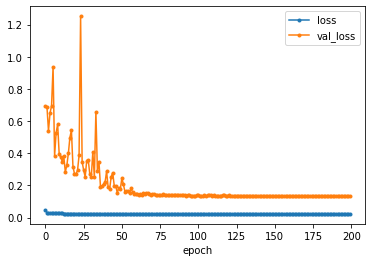

In [14]:
plot_history(history, ['loss', 'val_loss'])

## Computing Threshold Value
The network predicts 4 output channels:
1. The denoised input.
2. The background likelihoods.
3. The foreground likelihoods.
4. The border likelihoods.

We will threshold the foreground prediction image to obtain object segmentations. The optimal threshold is determined on the validation data. Additionally we can optimize the threshold for a given measure. In this case we choose the Average Precision (AP) measure.

In [15]:
model_name = 'DenoiSeg_DSB18_n0_noiseAugmentation_valTestAsWell_alpha.5'
basedir = 'models'
model = DenoiSeg(None, model_name, basedir)

Loading network weights from 'weights_best.h5'.


In [16]:
threshold, val_score = model.optimize_thresholds(val_images.astype(np.float32), val_masks, measure=measure_precision(), noise_augmentation=True)

print("The higest score of {} is achieved with threshold = {}.".format(np.round(val_score, 3), threshold))

Computing best threshold: 


/home/tbuchhol/Gitrepos/DenoiSeg/denoiseg/utils/compute_precision_threshold.py:7: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "pixel_sharing_bipartite" failed type inference due to: Invalid use of Function(<built-in function zeros>) with argument(s) of type(s): (UniTuple(int64 x 2), dtype=Function(<class 'int'>))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<built-in function zeros>)
[2] During: typing of call at /home/tbuchhol/Gitrepos/DenoiSeg/denoiseg/utils/compute_precision_threshold.py (10)


File "../../denoiseg/utils/compute_precision_threshold.py", line 10:
def pixel_sharing_bipartite(lab1, lab2):
    <source elided>
    assert lab1.shape == lab2.shape
    psg = np.zeros((lab1.max() + 

Score for threshold = 0.10 is 0.6332
Score for threshold = 0.15 is 0.6726
Score for threshold = 0.20 is 0.6936
Score for threshold = 0.25 is 0.7026
Score for threshold = 0.30 is 0.7203
Score for threshold = 0.35 is 0.7217
Score for threshold = 0.40 is 0.7246
Score for threshold = 0.45 is 0.7202
Score for threshold = 0.50 is 0.7110
Score for threshold = 0.55 is 0.7019
Score for threshold = 0.60 is 0.6969
Score for threshold = 0.65 is 0.6807
Score for threshold = 0.70 is 0.6733
Score for threshold = 0.75 is 0.6564
Score for threshold = 0.80 is 0.6405
Score for threshold = 0.85 is 0.5977
Score for threshold = 0.90 is 0.5322
Score for threshold = 0.95 is 0.4212
Score for threshold = 1.00 is 0.0000

The higest score of 0.725 is achieved with threshold = 0.4.


In [17]:
threshold_noAug, val_score_noAug = model.optimize_thresholds(val_images.astype(np.float32), val_masks, measure=measure_precision(), noise_augmentation=False)

print("The higest score of {} is achieved with threshold = {}.".format(np.round(val_score_noAug, 3), threshold_noAug))

Computing best threshold: 


Score for threshold = 0.10 is 0.5917
Score for threshold = 0.15 is 0.6676
Score for threshold = 0.20 is 0.6747
Score for threshold = 0.25 is 0.6807
Score for threshold = 0.30 is 0.6872
Score for threshold = 0.35 is 0.6844
Score for threshold = 0.40 is 0.6830
Score for threshold = 0.45 is 0.6723
Score for threshold = 0.50 is 0.6651
Score for threshold = 0.55 is 0.6532
Score for threshold = 0.60 is 0.6450
Score for threshold = 0.65 is 0.6345
Score for threshold = 0.70 is 0.6208
Score for threshold = 0.75 is 0.6063
Score for threshold = 0.80 is 0.5903
Score for threshold = 0.85 is 0.5547
Score for threshold = 0.90 is 0.5054
Score for threshold = 0.95 is 0.4226
Score for threshold = 1.00 is 0.0000

The higest score of 0.687 is achieved with threshold = 0.30000000000000004.


## Test Data
Finally we load the test data and run the prediction.

In [18]:
test_data =  np.load('data/DSB2018_{}/test/test_data.npz'.format(noise_level), allow_pickle=True)
test_images = test_data['X_test']
test_masks = test_data['Y_test']

In [19]:
predicted_images, precision_result = model.predict_label_masks(test_images, test_masks, threshold, 
                                                                   measure=measure_precision(), noise_augmentation=True)
print("Average precision over all test images with threshold = {} is {}.".format(threshold, np.round(precision_result, 3)))

Average precision over all test images with threshold = 0.4 is 0.674.


In [20]:
predicted_images_noAug, precision_result_noAug = model.predict_label_masks(test_images, test_masks, threshold_noAug, 
                                                                   measure=measure_precision(), noise_augmentation=False)
print("Average precision over all test images with threshold = {} is {}.".format(threshold_noAug, np.round(precision_result_noAug, 3)))

Average precision over all test images with threshold = 0.30000000000000004 is 0.607.


# Comparison

In [40]:
baseline = 0.578
baseline_sem = 0.01
baseline_noiseAugmentation = np.round(precision_result, 3)
denoiseg_alpha_05 = 0.625
denoiseg_alpha_05_sem = 0.008

In [55]:
import matplotlib
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

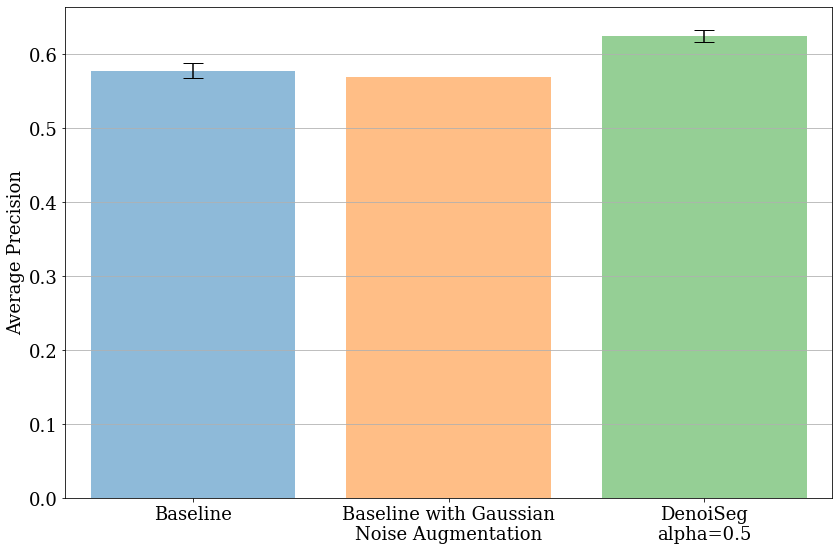

In [56]:
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(0, baseline, yerr=baseline_sem, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.bar(1, baseline_noiseAugmentation, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.bar(2, denoiseg_alpha_05, yerr=denoiseg_alpha_05_sem, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Baseline', 'Baseline with Gaussian\nNoise Augmentation', 'DenoiSeg\nalpha=0.5'])
ax.yaxis.grid(True)
ax.set_ylabel('Average Precision')
ax.set_xlim([-0.5, 2.5])

# Save the figure and show
plt.tight_layout()